# CIFAR vectorized LiRA example

This notebook mirrors A_cifar_main.ipynb but configures the LiRA attack to use the vectorized fast path.

It is safer to delete previous results for target and shadow models as it will train new models. 


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

train_config_path = "B_train_robust.yaml"
audit_config_path = "B_audit_robust.yaml"


In [2]:
from leakpro import LeakPro

RETRAIN_TARGET = True


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [3]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)
    

In [4]:
data_root = train_config["data"]["data_dir"]
data_path = os.path.join(os.getcwd(), data_root)

if RETRAIN_TARGET:
    # Load the CIFAR train and test datasets
    if train_config["data"]["dataset"] == "cifar10":
        trainset = CIFAR10(root=data_root, train=True, download=True)
        testset = CIFAR10(root=data_root, train=False, download=True)
    elif train_config["data"]["dataset"] == "cifar100":
        trainset = CIFAR100(root=data_root, train=True, download=True)
        testset = CIFAR100(root=data_root, train=False, download=True)
    else:
        raise ValueError("Unknown dataset type")
    
    train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
    test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255
    
    # Ensure train and test data looks correct
    assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
    assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
    assert train_data.shape[1] == 3, "Data should have 3 channels"
    assert test_data.shape[1] == 3, "Data should have 3 channels"
    assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
    assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"
    
    # Concatenate train and test data into the population
    data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
    targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
    # Create UserDataset object
    population_dataset = CifarInputHandler.UserDataset(data, targets)
    
    assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"
    
    # Store the population dataset to be used by LeakPro 
    dataset_name = train_config["data"]["dataset"]
    file_path =  data_root+"/"+ dataset_name + ".pkl"
    if not os.path.exists(file_path):
        with open(file_path, "wb") as file:
            pickle.dump(population_dataset, file)
            print(f"Save data to {file_path}")
            


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [5]:
if RETRAIN_TARGET:
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader
    import numpy as np
    
    train_fraction = train_config["data"]["f_train"]
    test_fraction = train_config["data"]["f_test"]
    batch_size = train_config["train"]["batch_size"]
    
    dataset_size = len(population_dataset)
    train_size = int(train_fraction * dataset_size) 
    test_size = int(test_fraction * dataset_size)
    print(f"original train size: {len(train_data)}, test size: {len(test_data)}")
    print(f"selected train size: {train_size}, test size: {test_size}")
    
    randomize_audit = False
    selected_index = np.arange(train_size + test_size)
    if randomize_audit:
        np.random.shuffle(selected_index)
    train_indices = selected_index[:train_size]
    test_indices = selected_index[train_size:(train_size+test_size)]
    
    # Now define the new target train and test sets
    train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
    test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())
    
    train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)
    
    # Evaluate mean and variance of the train data
    train_mean = train_subset.mean
    train_std = train_subset.std
    print (f"Train mean: {train_mean}, Train std: {train_std}")


original train size: 50000, test size: 10000
selected train size: 30000, test size: 30000
Train mean: tensor([[[0.4916]],

        [[0.4820]],

        [[0.4461]]]), Train std: tensor([[[0.2476]],

        [[0.2441]],

        [[0.2618]]])


### Train target model
With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [6]:
target_dir = train_config["run"]["log_dir"]
print("target_dir:", target_dir)


target_dir: ./B/target


In [7]:
if RETRAIN_TARGET:
    from torch import save, optim, nn
    from target_model_class import ResNet18, WideResNet
    
    # Train the model
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
        
    if train_config["data"]["dataset"] == "cifar10":
        num_classes = 10
    elif train_config["data"]["dataset"] == "cifar100":
        num_classes = 100
    else:
        raise ValueError("Invalid dataset name")
    
    # Create instance of target model
    #model = ResNet18(num_classes = num_classes)
    model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)
    
    # Read out the relevant parameters for training
    lr = train_config["train"]["learning_rate"]
    weight_decay = train_config["train"]["weight_decay"]
    momentum = train_config["train"]["momentum"]
    epochs = train_config["train"]["epochs"]
        
    # Create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # train target model
    train_result = CifarInputHandler().train(dataloader=train_loader,
                                model=model,
                                criterion=criterion,
                                optimizer=optimizer,
                                epochs=epochs)


Epoch 1/12: 100%|██████████| 106/106 [00:08<00:00, 11.81it/s, acc=0.3568, loss=1.7701]


Validation loss at epoch 1: 1.5457


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.5154, loss=1.3306]


Validation loss at epoch 2: 1.3271


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.54it/s, acc=0.6169, loss=1.0649]


Validation loss at epoch 3: 1.1159


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.51it/s, acc=0.7047, loss=0.8321]


Validation loss at epoch 4: 0.9446


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.7683, loss=0.6634]


Validation loss at epoch 5: 0.9205


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.52it/s, acc=0.8181, loss=0.5243]


Validation loss at epoch 6: 0.8093


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.8586, loss=0.4064]


Validation loss at epoch 7: 0.8928


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.56it/s, acc=0.9006, loss=0.2898]


Validation loss at epoch 8: 0.7599


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9518, loss=0.1530]


Validation loss at epoch 9: 0.7662


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.9856, loss=0.0630]


Validation loss at epoch 10: 0.7190


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.54it/s, acc=0.9975, loss=0.0259]


Validation loss at epoch 11: 0.6907


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.9992, loss=0.0167]


Validation loss at epoch 12: 0.6961


In [8]:
if RETRAIN_TARGET:
    # Evaluate on test set
    test_result = CifarInputHandler().eval(test_loader, model, criterion)
    
    # Store the model and metadata
    model = train_result.model
    model.to("cpu")
    #with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    with open(target_dir+"/target_model.pkl", "wb") as f:
        save(model.state_dict(), f)
    
    # Create metadata to be used by LeakPro
    meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                          optimizer = optimizer,
                                          loss_fn = criterion,
                                          dataloader = train_loader,
                                          test_result = test_result,
                                          epochs = epochs,
                                          train_indices = train_indices,
                                          test_indices = test_indices,
                                          dataset_name = dataset_name)
    
    with open(target_dir+"/model_metadata.pkl", "wb") as f:
        pickle.dump(meta_data, f)
    

Plot accuracy and test of training and test.

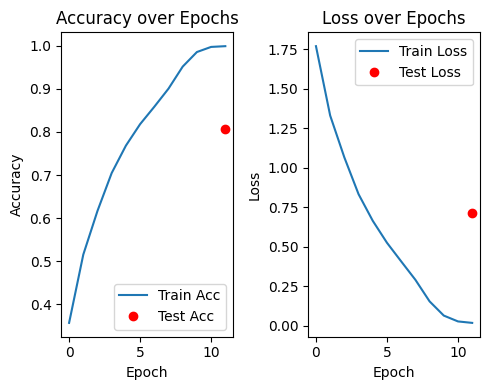

In [9]:
import matplotlib.pyplot as plt

if RETRAIN_TARGET:
    train_acc = train_result.metrics.extra["accuracy_history"]
    train_loss = train_result.metrics.extra["loss_history"]
    test_acc = test_result.accuracy
    test_loss = test_result.loss
    
    # Plot training and test accuracy
    plt.figure(figsize=(5, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    # Plot training and test loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Train shadow models for audit


In [10]:
from leakpro.schemas import LeakProConfig

with open(audit_config_path, "rb") as f:
    audit_configs = yaml.safe_load(f)
    
leakpro_configs = LeakProConfig(**audit_configs)


In [11]:
shadow_dir = audit_configs["audit"]["output_dir"]
print("shadow_dir:", shadow_dir)


shadow_dir: ./B/output


In [12]:
# Instantiate LeakPro with audit configuration
leakpro = LeakPro(CifarInputHandler, audit_config_path)


2025-11-10 18:34:03,494 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
11/10/2025 18:34:03:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-11-10 18:34:03,546 INFO     Loaded target model metadata from ./B/target/model_metadata.pkl
11/10/2025 18:34:03:INFO:Loaded target model metadata from ./B/target/model_metadata.pkl
2025-11-10 18:34:03,623 INFO     Loaded target model from ./B/target
11/10/2025 18:34:03:INFO:Loaded target model from ./B/target
2025-11-10 18:34:04,987 INFO     Loaded population dataset from ./data/cifar10.pkl
11/10/2025 18:34:04:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-11-10 18:34:10.208974: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 18:34:10.2771

In [13]:
# Run the audit
mia_results = leakpro.run_audit(create_pdf=True)


2025-11-10 18:34:30,172 INFO     Preparing attack: lira
11/10/2025 18:34:30:INFO:Preparing attack: lira
2025-11-10 18:34:30,651 INFO     Training shadow model 0 on 30000 points
11/10/2025 18:34:30:INFO:Training shadow model 0 on 30000 points
Epoch 1/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.3413, loss=1.8412]


Validation loss at epoch 1: 1.5886


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.5029, loss=1.3607]


Validation loss at epoch 2: 1.3078


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.54it/s, acc=0.6205, loss=1.0551]


Validation loss at epoch 3: 1.1859


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.6984, loss=0.8516]


Validation loss at epoch 4: 0.8849


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s, acc=0.7594, loss=0.6856]


Validation loss at epoch 5: 1.2062


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.8017, loss=0.5734]


Validation loss at epoch 6: 0.8282


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.8423, loss=0.4565]


Validation loss at epoch 7: 0.9995


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8867, loss=0.3323]


Validation loss at epoch 8: 0.9141


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.56it/s, acc=0.9312, loss=0.2099]


Validation loss at epoch 9: 0.7722


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.9726, loss=0.1034]


Validation loss at epoch 10: 0.7433


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9925, loss=0.0448]


Validation loss at epoch 11: 0.7333


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.50it/s, acc=0.9976, loss=0.0265]


Validation loss at epoch 12: 0.7402


2025-11-10 18:36:19,705 INFO     Training shadow model 0 complete
11/10/2025 18:36:19:INFO:Training shadow model 0 complete
2025-11-10 18:36:19,731 INFO     Saved shadow model 0 to ./B/output/attack_objects/shadow_model
11/10/2025 18:36:19:INFO:Saved shadow model 0 to ./B/output/attack_objects/shadow_model
2025-11-10 18:36:19,734 INFO     Storing metadata for shadow model 0
11/10/2025 18:36:19:INFO:Storing metadata for shadow model 0
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]
2025-11-10 18:36:30,249 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_0_logits.npy
11/10/2025 18:36:30:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_0_logits.npy
2025-11-10 18:36:30,260 INFO     Metadata for shadow model 0 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:36:30:INFO:Metadata for shadow model 0 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:36:30,647 INFO     Training shadow model 1 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.2643


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s, acc=0.5997, loss=1.1161]


Validation loss at epoch 2: 1.3163


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6793, loss=0.8981]


Validation loss at epoch 3: 1.0112


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.50it/s, acc=0.7446, loss=0.7280]


Validation loss at epoch 4: 0.8354


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.7902, loss=0.6003]


Validation loss at epoch 5: 0.8698


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.8412, loss=0.4595]


Validation loss at epoch 6: 1.3820


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s, acc=0.8862, loss=0.3347]


Validation loss at epoch 7: 0.8745


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 11.84it/s, acc=0.9340, loss=0.1976]


Validation loss at epoch 8: 0.9306


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9763, loss=0.0865]


Validation loss at epoch 9: 0.8939


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9970, loss=0.0246]


Validation loss at epoch 10: 0.7911


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9998, loss=0.0101]


Validation loss at epoch 11: 0.7850


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9999, loss=0.0079]


Validation loss at epoch 12: 0.7892


2025-11-10 18:38:20,273 INFO     Training shadow model 1 complete
11/10/2025 18:38:20:INFO:Training shadow model 1 complete
2025-11-10 18:38:20,299 INFO     Saved shadow model 1 to ./B/output/attack_objects/shadow_model
11/10/2025 18:38:20:INFO:Saved shadow model 1 to ./B/output/attack_objects/shadow_model
2025-11-10 18:38:20,301 INFO     Storing metadata for shadow model 1
11/10/2025 18:38:20:INFO:Storing metadata for shadow model 1
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.87s/it]
2025-11-10 18:38:30,974 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_1_logits.npy
11/10/2025 18:38:30:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_1_logits.npy
2025-11-10 18:38:30,981 INFO     Metadata for shadow model 1 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:38:30:INFO:Metadata for shadow model 1 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:38:31,442 INFO     Training shadow model 2 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.5242


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.5814, loss=1.1550]


Validation loss at epoch 2: 1.0844


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.6811, loss=0.9026]


Validation loss at epoch 3: 1.2507


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7451, loss=0.7277]


Validation loss at epoch 4: 0.9075


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.7950, loss=0.5906]


Validation loss at epoch 5: 0.9534


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.8449, loss=0.4492]


Validation loss at epoch 6: 1.1769


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.8971, loss=0.3047]


Validation loss at epoch 7: 0.8921


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9433, loss=0.1747]


Validation loss at epoch 8: 1.1787


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9833, loss=0.0675]


Validation loss at epoch 9: 0.8937


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9980, loss=0.0194]


Validation loss at epoch 10: 0.8029


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9997, loss=0.0092]


Validation loss at epoch 11: 0.8206


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9999, loss=0.0071]


Validation loss at epoch 12: 0.8240


2025-11-10 18:40:21,439 INFO     Training shadow model 2 complete
11/10/2025 18:40:21:INFO:Training shadow model 2 complete
2025-11-10 18:40:21,467 INFO     Saved shadow model 2 to ./B/output/attack_objects/shadow_model
11/10/2025 18:40:21:INFO:Saved shadow model 2 to ./B/output/attack_objects/shadow_model
2025-11-10 18:40:21,468 INFO     Storing metadata for shadow model 2
11/10/2025 18:40:21:INFO:Storing metadata for shadow model 2
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.39s/it]
2025-11-10 18:40:32,583 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_2_logits.npy
11/10/2025 18:40:32:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_2_logits.npy
2025-11-10 18:40:32,590 INFO     Metadata for shadow model 2 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:40:32:INFO:Metadata for shadow model 2 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:40:33,025 INFO     Training shadow model 3 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.6567


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.4870, loss=1.3833]


Validation loss at epoch 2: 1.3866


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.5854, loss=1.1458]


Validation loss at epoch 3: 1.1493


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.6581, loss=0.9580]


Validation loss at epoch 4: 1.0396


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.7181, loss=0.7945]


Validation loss at epoch 5: 0.8636


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.7703, loss=0.6516]


Validation loss at epoch 6: 1.1067


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.8203, loss=0.5179]


Validation loss at epoch 7: 0.7877


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.8646, loss=0.3905]


Validation loss at epoch 8: 0.8910


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9136, loss=0.2627]


Validation loss at epoch 9: 0.8617


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9550, loss=0.1496]


Validation loss at epoch 10: 0.7658


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9845, loss=0.0703]


Validation loss at epoch 11: 0.7819


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9944, loss=0.0431]


Validation loss at epoch 12: 0.7660


2025-11-10 18:42:22,285 INFO     Training shadow model 3 complete
11/10/2025 18:42:22:INFO:Training shadow model 3 complete
2025-11-10 18:42:22,310 INFO     Saved shadow model 3 to ./B/output/attack_objects/shadow_model
11/10/2025 18:42:22:INFO:Saved shadow model 3 to ./B/output/attack_objects/shadow_model
2025-11-10 18:42:22,312 INFO     Storing metadata for shadow model 3
11/10/2025 18:42:22:INFO:Storing metadata for shadow model 3
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]
2025-11-10 18:42:32,924 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_3_logits.npy
11/10/2025 18:42:32:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_3_logits.npy
2025-11-10 18:42:32,930 INFO     Metadata for shadow model 3 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:42:32:INFO:Metadata for shadow model 3 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:42:33,327 INFO     Training shadow model 4 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.4864


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.5827, loss=1.1619]


Validation loss at epoch 2: 1.2932


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6771, loss=0.9088]


Validation loss at epoch 3: 1.2117


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 11.84it/s, acc=0.7439, loss=0.7288]


Validation loss at epoch 4: 0.8532


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.7973, loss=0.5772]


Validation loss at epoch 5: 0.9235


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.8432, loss=0.4536]


Validation loss at epoch 6: 0.8233


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.8936, loss=0.3149]


Validation loss at epoch 7: 1.0052


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9357, loss=0.1950]


Validation loss at epoch 8: 0.9793


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9786, loss=0.0798]


Validation loss at epoch 9: 0.8198


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9970, loss=0.0238]


Validation loss at epoch 10: 0.7392


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9996, loss=0.0103]


Validation loss at epoch 11: 0.7547


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9998, loss=0.0080]


Validation loss at epoch 12: 0.7462


2025-11-10 18:44:23,204 INFO     Training shadow model 4 complete
11/10/2025 18:44:23:INFO:Training shadow model 4 complete
2025-11-10 18:44:23,229 INFO     Saved shadow model 4 to ./B/output/attack_objects/shadow_model
11/10/2025 18:44:23:INFO:Saved shadow model 4 to ./B/output/attack_objects/shadow_model
2025-11-10 18:44:23,231 INFO     Storing metadata for shadow model 4
11/10/2025 18:44:23:INFO:Storing metadata for shadow model 4
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.36s/it]
2025-11-10 18:44:34,345 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_4_logits.npy
11/10/2025 18:44:34:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_4_logits.npy
2025-11-10 18:44:34,352 INFO     Metadata for shadow model 4 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:44:34:INFO:Metadata for shadow model 4 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:44:34,766 INFO     Training shadow model 5 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.5079


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5897, loss=1.1394]


Validation loss at epoch 2: 1.3125


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.6795, loss=0.8933]


Validation loss at epoch 3: 1.0141


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7509, loss=0.7141]


Validation loss at epoch 4: 0.8888


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8007, loss=0.5687]


Validation loss at epoch 5: 0.8916


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8443, loss=0.4498]


Validation loss at epoch 6: 1.0962


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8878, loss=0.3262]


Validation loss at epoch 7: 0.7472


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9378, loss=0.1897]


Validation loss at epoch 8: 0.8386


Epoch 9/12: 100%|██████████| 106/106 [00:09<00:00, 11.66it/s, acc=0.9761, loss=0.0857]


Validation loss at epoch 9: 0.8160


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9963, loss=0.0274]


Validation loss at epoch 10: 0.7370


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9994, loss=0.0116]


Validation loss at epoch 11: 0.7401


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9998, loss=0.0086]


Validation loss at epoch 12: 0.7401


2025-11-10 18:46:24,846 INFO     Training shadow model 5 complete
11/10/2025 18:46:24:INFO:Training shadow model 5 complete
2025-11-10 18:46:24,871 INFO     Saved shadow model 5 to ./B/output/attack_objects/shadow_model
11/10/2025 18:46:24:INFO:Saved shadow model 5 to ./B/output/attack_objects/shadow_model
2025-11-10 18:46:24,873 INFO     Storing metadata for shadow model 5
11/10/2025 18:46:24:INFO:Storing metadata for shadow model 5
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.95s/it]
2025-11-10 18:46:35,608 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_5_logits.npy
11/10/2025 18:46:35:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_5_logits.npy
2025-11-10 18:46:35,615 INFO     Metadata for shadow model 5 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:46:35:INFO:Metadata for shadow model 5 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:46:36,020 INFO     Training shadow model 6 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.3932


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.5773, loss=1.1763]


Validation loss at epoch 2: 1.2338


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.6657, loss=0.9322]


Validation loss at epoch 3: 1.1715


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.7362, loss=0.7447]


Validation loss at epoch 4: 1.0258


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7912, loss=0.5966]


Validation loss at epoch 5: 0.9475


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.8368, loss=0.4625]


Validation loss at epoch 6: 0.8545


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.8876, loss=0.3281]


Validation loss at epoch 7: 1.0232


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9359, loss=0.1957]


Validation loss at epoch 8: 0.9834


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.9809, loss=0.0736]


Validation loss at epoch 9: 0.9163


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9980, loss=0.0224]


Validation loss at epoch 10: 0.8749


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.51it/s, acc=0.9998, loss=0.0096]


Validation loss at epoch 11: 0.8467


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.9999, loss=0.0076]


Validation loss at epoch 12: 0.8505


2025-11-10 18:48:25,517 INFO     Training shadow model 6 complete
11/10/2025 18:48:25:INFO:Training shadow model 6 complete
2025-11-10 18:48:25,547 INFO     Saved shadow model 6 to ./B/output/attack_objects/shadow_model
11/10/2025 18:48:25:INFO:Saved shadow model 6 to ./B/output/attack_objects/shadow_model
2025-11-10 18:48:25,549 INFO     Storing metadata for shadow model 6
11/10/2025 18:48:25:INFO:Storing metadata for shadow model 6
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.48s/it]
2025-11-10 18:48:36,735 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_6_logits.npy
11/10/2025 18:48:36:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_6_logits.npy
2025-11-10 18:48:36,741 INFO     Metadata for shadow model 6 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:48:36:INFO:Metadata for shadow model 6 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:48:37,139 INFO     Training shadow model 7 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.5568


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.4983, loss=1.3667]


Validation loss at epoch 2: 1.3007


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.6113, loss=1.0794]


Validation loss at epoch 3: 1.1768


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.6841, loss=0.8831]


Validation loss at epoch 4: 0.9284


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7494, loss=0.7130]


Validation loss at epoch 5: 0.8193


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7970, loss=0.5820]


Validation loss at epoch 6: 0.8375


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8361, loss=0.4704]


Validation loss at epoch 7: 1.1419


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8831, loss=0.3380]


Validation loss at epoch 8: 0.7616


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9281, loss=0.2200]


Validation loss at epoch 9: 0.8782


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.9679, loss=0.1114]


Validation loss at epoch 10: 0.7944


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9899, loss=0.0508]


Validation loss at epoch 11: 0.7603


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9962, loss=0.0316]


Validation loss at epoch 12: 0.7338


2025-11-10 18:50:26,716 INFO     Training shadow model 7 complete
11/10/2025 18:50:26:INFO:Training shadow model 7 complete
2025-11-10 18:50:26,742 INFO     Saved shadow model 7 to ./B/output/attack_objects/shadow_model
11/10/2025 18:50:26:INFO:Saved shadow model 7 to ./B/output/attack_objects/shadow_model
2025-11-10 18:50:26,744 INFO     Storing metadata for shadow model 7
11/10/2025 18:50:26:INFO:Storing metadata for shadow model 7
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.10s/it]
2025-11-10 18:50:37,629 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_7_logits.npy
11/10/2025 18:50:37:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_7_logits.npy
2025-11-10 18:50:37,638 INFO     Metadata for shadow model 7 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:50:37:INFO:Metadata for shadow model 7 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:50:38,123 INFO     Training shadow model 8 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 2.0642


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.3894, loss=1.6302]


Validation loss at epoch 2: 1.6925


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.5051, loss=1.3528]


Validation loss at epoch 3: 1.6433


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.5943, loss=1.1256]


Validation loss at epoch 4: 1.2189


Epoch 5/12: 100%|██████████| 106/106 [00:09<00:00, 11.72it/s, acc=0.6660, loss=0.9424]


Validation loss at epoch 5: 1.0749


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.7196, loss=0.7987]


Validation loss at epoch 6: 0.9148


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.7666, loss=0.6726]


Validation loss at epoch 7: 0.7880


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8044, loss=0.5577]


Validation loss at epoch 8: 0.8063


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8509, loss=0.4331]


Validation loss at epoch 9: 0.8171


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.8958, loss=0.3111]


Validation loss at epoch 10: 0.7556


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9354, loss=0.2123]


Validation loss at epoch 11: 0.7122


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.9607, loss=0.1535]


Validation loss at epoch 12: 0.7126


2025-11-10 18:52:28,246 INFO     Training shadow model 8 complete
11/10/2025 18:52:28:INFO:Training shadow model 8 complete
2025-11-10 18:52:28,277 INFO     Saved shadow model 8 to ./B/output/attack_objects/shadow_model
11/10/2025 18:52:28:INFO:Saved shadow model 8 to ./B/output/attack_objects/shadow_model
2025-11-10 18:52:28,278 INFO     Storing metadata for shadow model 8
11/10/2025 18:52:28:INFO:Storing metadata for shadow model 8
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.91s/it]
2025-11-10 18:52:38,900 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_8_logits.npy
11/10/2025 18:52:38:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_8_logits.npy
2025-11-10 18:52:38,907 INFO     Metadata for shadow model 8 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:52:38:INFO:Metadata for shadow model 8 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:52:39,265 INFO     Training shadow model 9 on 30000 points
11/10/2025 18

Validation loss at epoch 1: 1.5851


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5604, loss=1.2272]


Validation loss at epoch 2: 1.2401


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.6576, loss=0.9646]


Validation loss at epoch 3: 0.9747


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7326, loss=0.7535]


Validation loss at epoch 4: 0.8738


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7906, loss=0.5959]


Validation loss at epoch 5: 0.8887


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8389, loss=0.4651]


Validation loss at epoch 6: 0.9228


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8841, loss=0.3395]


Validation loss at epoch 7: 0.8315


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9326, loss=0.2011]


Validation loss at epoch 8: 1.1114


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9776, loss=0.0851]


Validation loss at epoch 9: 0.7914


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 11.82it/s, acc=0.9967, loss=0.0271]


Validation loss at epoch 10: 0.7414


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9994, loss=0.0117]


Validation loss at epoch 11: 0.7439


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9997, loss=0.0091]


Validation loss at epoch 12: 0.7434


2025-11-10 18:54:29,341 INFO     Training shadow model 9 complete
11/10/2025 18:54:29:INFO:Training shadow model 9 complete
2025-11-10 18:54:29,368 INFO     Saved shadow model 9 to ./B/output/attack_objects/shadow_model
11/10/2025 18:54:29:INFO:Saved shadow model 9 to ./B/output/attack_objects/shadow_model
2025-11-10 18:54:29,370 INFO     Storing metadata for shadow model 9
11/10/2025 18:54:29:INFO:Storing metadata for shadow model 9
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.97s/it]
2025-11-10 18:54:40,092 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_9_logits.npy
11/10/2025 18:54:40:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_9_logits.npy
2025-11-10 18:54:40,098 INFO     Metadata for shadow model 9 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:54:40:INFO:Metadata for shadow model 9 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:54:40,473 INFO     Training shadow model 10 on 30000 points
11/10/2025 1

Validation loss at epoch 1: 1.3726


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.5720, loss=1.1880]


Validation loss at epoch 2: 1.2807


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.6691, loss=0.9272]


Validation loss at epoch 3: 1.0872


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.7379, loss=0.7492]


Validation loss at epoch 4: 1.0858


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7911, loss=0.5931]


Validation loss at epoch 5: 0.8718


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8400, loss=0.4606]


Validation loss at epoch 6: 1.0807


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.8887, loss=0.3247]


Validation loss at epoch 7: 0.8628


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9362, loss=0.1911]


Validation loss at epoch 8: 0.8493


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9808, loss=0.0744]


Validation loss at epoch 9: 0.8967


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9984, loss=0.0202]


Validation loss at epoch 10: 0.8221


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9997, loss=0.0093]


Validation loss at epoch 11: 0.8133


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9998, loss=0.0074]


Validation loss at epoch 12: 0.8217


2025-11-10 18:56:30,204 INFO     Training shadow model 10 complete
11/10/2025 18:56:30:INFO:Training shadow model 10 complete
2025-11-10 18:56:30,231 INFO     Saved shadow model 10 to ./B/output/attack_objects/shadow_model
11/10/2025 18:56:30:INFO:Saved shadow model 10 to ./B/output/attack_objects/shadow_model
2025-11-10 18:56:30,233 INFO     Storing metadata for shadow model 10
11/10/2025 18:56:30:INFO:Storing metadata for shadow model 10
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.98s/it]
2025-11-10 18:56:40,952 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_10_logits.npy
11/10/2025 18:56:40:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_10_logits.npy
2025-11-10 18:56:40,959 INFO     Metadata for shadow model 10 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:56:40:INFO:Metadata for shadow model 10 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:56:41,350 INFO     Training shadow model 11 on 30000 points
11

Validation loss at epoch 1: 1.6485


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.5714, loss=1.1866]


Validation loss at epoch 2: 1.3113


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6674, loss=0.9262]


Validation loss at epoch 3: 1.2336


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.7401, loss=0.7435]


Validation loss at epoch 4: 0.9944


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7923, loss=0.5989]


Validation loss at epoch 5: 1.0570


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.8393, loss=0.4619]


Validation loss at epoch 6: 0.8429


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.8862, loss=0.3306]


Validation loss at epoch 7: 0.9946


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s, acc=0.9395, loss=0.1862]


Validation loss at epoch 8: 0.9624


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9787, loss=0.0796]


Validation loss at epoch 9: 0.8218


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9967, loss=0.0242]


Validation loss at epoch 10: 0.7985


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9997, loss=0.0096]


Validation loss at epoch 11: 0.8003


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9998, loss=0.0077]


Validation loss at epoch 12: 0.8089


2025-11-10 18:58:31,998 INFO     Training shadow model 11 complete
11/10/2025 18:58:31:INFO:Training shadow model 11 complete
2025-11-10 18:58:32,025 INFO     Saved shadow model 11 to ./B/output/attack_objects/shadow_model
11/10/2025 18:58:32:INFO:Saved shadow model 11 to ./B/output/attack_objects/shadow_model
2025-11-10 18:58:32,027 INFO     Storing metadata for shadow model 11
11/10/2025 18:58:32:INFO:Storing metadata for shadow model 11
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.89s/it]
2025-11-10 18:58:42,649 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_11_logits.npy
11/10/2025 18:58:42:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_11_logits.npy
2025-11-10 18:58:42,655 INFO     Metadata for shadow model 11 stored in ./B/output/attack_objects/shadow_model
11/10/2025 18:58:42:INFO:Metadata for shadow model 11 stored in ./B/output/attack_objects/shadow_model
2025-11-10 18:58:43,021 INFO     Training shadow model 12 on 30000 points
11

Validation loss at epoch 1: 1.5901


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.09it/s, acc=0.5220, loss=1.3107]


Validation loss at epoch 2: 1.3667


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.6366, loss=1.0116]


Validation loss at epoch 3: 1.0142


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.7136, loss=0.8130]


Validation loss at epoch 4: 0.9881


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7680, loss=0.6680]


Validation loss at epoch 5: 0.8601


Epoch 6/12: 100%|██████████| 106/106 [00:09<00:00, 11.75it/s, acc=0.8069, loss=0.5500]


Validation loss at epoch 6: 0.9455


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.8521, loss=0.4277]


Validation loss at epoch 7: 0.8365


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.8967, loss=0.3053]


Validation loss at epoch 8: 1.0269


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9386, loss=0.1889]


Validation loss at epoch 9: 0.8146


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9786, loss=0.0840]


Validation loss at epoch 10: 0.7843


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9956, loss=0.0349]


Validation loss at epoch 11: 0.7696


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9985, loss=0.0217]


Validation loss at epoch 12: 0.7503


2025-11-10 19:00:33,066 INFO     Training shadow model 12 complete
11/10/2025 19:00:33:INFO:Training shadow model 12 complete
2025-11-10 19:00:33,094 INFO     Saved shadow model 12 to ./B/output/attack_objects/shadow_model
11/10/2025 19:00:33:INFO:Saved shadow model 12 to ./B/output/attack_objects/shadow_model
2025-11-10 19:00:33,096 INFO     Storing metadata for shadow model 12
11/10/2025 19:00:33:INFO:Storing metadata for shadow model 12
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]
2025-11-10 19:00:43,654 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_12_logits.npy
11/10/2025 19:00:43:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_12_logits.npy
2025-11-10 19:00:43,661 INFO     Metadata for shadow model 12 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:00:43:INFO:Metadata for shadow model 12 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:00:44,020 INFO     Training shadow model 13 on 30000 points
11

Validation loss at epoch 1: 1.4282


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.5706, loss=1.1871]


Validation loss at epoch 2: 1.4101


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.6674, loss=0.9415]


Validation loss at epoch 3: 0.9225


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7400, loss=0.7482]


Validation loss at epoch 4: 0.8897


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.7913, loss=0.5994]


Validation loss at epoch 5: 0.8358


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8356, loss=0.4748]


Validation loss at epoch 6: 0.8223


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.8801, loss=0.3462]


Validation loss at epoch 7: 0.9385


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9319, loss=0.2082]


Validation loss at epoch 8: 1.2099


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9737, loss=0.0934]


Validation loss at epoch 9: 0.8841


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9965, loss=0.0281]


Validation loss at epoch 10: 0.7584


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 11.81it/s, acc=0.9998, loss=0.0115]


Validation loss at epoch 11: 0.7797


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.50it/s, acc=0.9999, loss=0.0086]


Validation loss at epoch 12: 0.7791


2025-11-10 19:02:34,279 INFO     Training shadow model 13 complete
11/10/2025 19:02:34:INFO:Training shadow model 13 complete
2025-11-10 19:02:34,304 INFO     Saved shadow model 13 to ./B/output/attack_objects/shadow_model
11/10/2025 19:02:34:INFO:Saved shadow model 13 to ./B/output/attack_objects/shadow_model
2025-11-10 19:02:34,306 INFO     Storing metadata for shadow model 13
11/10/2025 19:02:34:INFO:Storing metadata for shadow model 13
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
2025-11-10 19:02:44,885 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_13_logits.npy
11/10/2025 19:02:44:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_13_logits.npy
2025-11-10 19:02:44,893 INFO     Metadata for shadow model 13 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:02:44:INFO:Metadata for shadow model 13 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:02:45,367 INFO     Training shadow model 14 on 30000 points
11

Validation loss at epoch 1: 1.7528


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.05it/s, acc=0.4194, loss=1.5599]


Validation loss at epoch 2: 1.5884


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.5269, loss=1.3054]


Validation loss at epoch 3: 1.3554


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.6172, loss=1.0644]


Validation loss at epoch 4: 1.1656


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.6858, loss=0.8810]


Validation loss at epoch 5: 1.0103


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.7430, loss=0.7260]


Validation loss at epoch 6: 0.8609


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7914, loss=0.5969]


Validation loss at epoch 7: 0.8936


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8304, loss=0.4828]


Validation loss at epoch 8: 0.7328


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.8744, loss=0.3638]


Validation loss at epoch 9: 0.8495


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9183, loss=0.2484]


Validation loss at epoch 10: 0.6661


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.9549, loss=0.1556]


Validation loss at epoch 11: 0.6938


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9747, loss=0.1078]


Validation loss at epoch 12: 0.6787


2025-11-10 19:04:35,252 INFO     Training shadow model 14 complete
11/10/2025 19:04:35:INFO:Training shadow model 14 complete
2025-11-10 19:04:35,287 INFO     Saved shadow model 14 to ./B/output/attack_objects/shadow_model
11/10/2025 19:04:35:INFO:Saved shadow model 14 to ./B/output/attack_objects/shadow_model
2025-11-10 19:04:35,289 INFO     Storing metadata for shadow model 14
11/10/2025 19:04:35:INFO:Storing metadata for shadow model 14
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]
2025-11-10 19:04:46,902 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_14_logits.npy
11/10/2025 19:04:46:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_14_logits.npy
2025-11-10 19:04:46,910 INFO     Metadata for shadow model 14 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:04:46:INFO:Metadata for shadow model 14 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:04:47,370 INFO     Training shadow model 15 on 30000 points
11

Validation loss at epoch 1: 1.5667


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.5086, loss=1.3478]


Validation loss at epoch 2: 1.2548


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.6117, loss=1.0774]


Validation loss at epoch 3: 1.2298


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.6917, loss=0.8708]


Validation loss at epoch 4: 1.0923


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.7531, loss=0.7013]


Validation loss at epoch 5: 1.0071


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.14it/s, acc=0.8014, loss=0.5658]


Validation loss at epoch 6: 0.9110


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.8487, loss=0.4384]


Validation loss at epoch 7: 0.7865


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8969, loss=0.3022]


Validation loss at epoch 8: 0.8845


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9470, loss=0.1698]


Validation loss at epoch 9: 1.0108


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9841, loss=0.0672]


Validation loss at epoch 10: 0.7473


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9971, loss=0.0261]


Validation loss at epoch 11: 0.7502


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.9991, loss=0.0170]


Validation loss at epoch 12: 0.7477


2025-11-10 19:06:38,072 INFO     Training shadow model 15 complete
11/10/2025 19:06:38:INFO:Training shadow model 15 complete
2025-11-10 19:06:38,100 INFO     Saved shadow model 15 to ./B/output/attack_objects/shadow_model
11/10/2025 19:06:38:INFO:Saved shadow model 15 to ./B/output/attack_objects/shadow_model
2025-11-10 19:06:38,102 INFO     Storing metadata for shadow model 15
11/10/2025 19:06:38:INFO:Storing metadata for shadow model 15
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00, 10.00s/it]
2025-11-10 19:06:48,889 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_15_logits.npy
11/10/2025 19:06:48:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_15_logits.npy
2025-11-10 19:06:48,896 INFO     Metadata for shadow model 15 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:06:48:INFO:Metadata for shadow model 15 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:06:49,307 INFO     Training shadow model 16 on 30000 points
11

Validation loss at epoch 1: 1.4634


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.5392, loss=1.2775]


Validation loss at epoch 2: 1.2651


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.6306, loss=1.0318]


Validation loss at epoch 3: 1.2973


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.7012, loss=0.8359]


Validation loss at epoch 4: 1.1600


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.09it/s, acc=0.7588, loss=0.6876]


Validation loss at epoch 5: 0.8586


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.8047, loss=0.5539]


Validation loss at epoch 6: 1.0078


Epoch 7/12: 100%|██████████| 106/106 [00:09<00:00, 11.66it/s, acc=0.8497, loss=0.4281]


Validation loss at epoch 7: 0.7998


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.8982, loss=0.2981]


Validation loss at epoch 8: 0.8762


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9481, loss=0.1656]


Validation loss at epoch 9: 0.9716


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9843, loss=0.0685]


Validation loss at epoch 10: 0.8328


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9982, loss=0.0256]


Validation loss at epoch 11: 0.7838


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9993, loss=0.0167]


Validation loss at epoch 12: 0.7841


2025-11-10 19:08:39,405 INFO     Training shadow model 16 complete
11/10/2025 19:08:39:INFO:Training shadow model 16 complete
2025-11-10 19:08:39,432 INFO     Saved shadow model 16 to ./B/output/attack_objects/shadow_model
11/10/2025 19:08:39:INFO:Saved shadow model 16 to ./B/output/attack_objects/shadow_model
2025-11-10 19:08:39,434 INFO     Storing metadata for shadow model 16
11/10/2025 19:08:39:INFO:Storing metadata for shadow model 16
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
2025-11-10 19:08:50,143 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_16_logits.npy
11/10/2025 19:08:50:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_16_logits.npy
2025-11-10 19:08:50,150 INFO     Metadata for shadow model 16 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:08:50:INFO:Metadata for shadow model 16 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:08:50,550 INFO     Training shadow model 17 on 30000 points
11

Validation loss at epoch 1: 1.4454


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.10it/s, acc=0.5713, loss=1.1853]


Validation loss at epoch 2: 1.1971


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.6649, loss=0.9455]


Validation loss at epoch 3: 1.0796


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.7296, loss=0.7757]


Validation loss at epoch 4: 0.8843


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7857, loss=0.6145]


Validation loss at epoch 5: 0.9180


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8308, loss=0.4868]


Validation loss at epoch 6: 0.9291


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8757, loss=0.3573]


Validation loss at epoch 7: 1.1058


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9213, loss=0.2317]


Validation loss at epoch 8: 0.8938


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9679, loss=0.1069]


Validation loss at epoch 9: 0.8706


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9952, loss=0.0337]


Validation loss at epoch 10: 0.7901


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9990, loss=0.0142]


Validation loss at epoch 11: 0.7913


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 11.81it/s, acc=0.9996, loss=0.0106]


Validation loss at epoch 12: 0.7960


2025-11-10 19:10:40,430 INFO     Training shadow model 17 complete
11/10/2025 19:10:40:INFO:Training shadow model 17 complete
2025-11-10 19:10:40,462 INFO     Saved shadow model 17 to ./B/output/attack_objects/shadow_model
11/10/2025 19:10:40:INFO:Saved shadow model 17 to ./B/output/attack_objects/shadow_model
2025-11-10 19:10:40,464 INFO     Storing metadata for shadow model 17
11/10/2025 19:10:40:INFO:Storing metadata for shadow model 17
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.94s/it]
2025-11-10 19:10:51,209 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_17_logits.npy
11/10/2025 19:10:51:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_17_logits.npy
2025-11-10 19:10:51,217 INFO     Metadata for shadow model 17 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:10:51:INFO:Metadata for shadow model 17 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:10:51,587 INFO     Training shadow model 18 on 30000 points
11

Validation loss at epoch 1: 1.6499


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.05it/s, acc=0.4769, loss=1.4278]


Validation loss at epoch 2: 1.4943


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.5837, loss=1.1604]


Validation loss at epoch 3: 1.1839


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.6616, loss=0.9442]


Validation loss at epoch 4: 1.1349


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7219, loss=0.7821]


Validation loss at epoch 5: 0.9231


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.7745, loss=0.6462]


Validation loss at epoch 6: 0.8187


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8145, loss=0.5274]


Validation loss at epoch 7: 0.7193


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8604, loss=0.4023]


Validation loss at epoch 8: 0.8828


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9051, loss=0.2804]


Validation loss at epoch 9: 0.8469


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9523, loss=0.1631]


Validation loss at epoch 10: 0.7312


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9818, loss=0.0800]


Validation loss at epoch 11: 0.7197


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9936, loss=0.0496]


Validation loss at epoch 12: 0.7242


2025-11-10 19:12:41,419 INFO     Training shadow model 18 complete
11/10/2025 19:12:41:INFO:Training shadow model 18 complete
2025-11-10 19:12:41,452 INFO     Saved shadow model 18 to ./B/output/attack_objects/shadow_model
11/10/2025 19:12:41:INFO:Saved shadow model 18 to ./B/output/attack_objects/shadow_model
2025-11-10 19:12:41,454 INFO     Storing metadata for shadow model 18
11/10/2025 19:12:41:INFO:Storing metadata for shadow model 18
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
2025-11-10 19:12:52,030 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_18_logits.npy
11/10/2025 19:12:52:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_18_logits.npy
2025-11-10 19:12:52,038 INFO     Metadata for shadow model 18 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:12:52:INFO:Metadata for shadow model 18 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:12:52,410 INFO     Training shadow model 19 on 30000 points
11

Validation loss at epoch 1: 1.7298


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.4513, loss=1.4666]


Validation loss at epoch 2: 1.7493


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.5536, loss=1.2224]


Validation loss at epoch 3: 1.2194


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.6423, loss=0.9976]


Validation loss at epoch 4: 1.1380


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.6981, loss=0.8461]


Validation loss at epoch 5: 0.9867


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7531, loss=0.7009]


Validation loss at epoch 6: 1.0862


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7987, loss=0.5736]


Validation loss at epoch 7: 0.8630


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8408, loss=0.4550]


Validation loss at epoch 8: 0.9759


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8874, loss=0.3297]


Validation loss at epoch 9: 0.7600


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9347, loss=0.2036]


Validation loss at epoch 10: 0.7979


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9709, loss=0.1116]


Validation loss at epoch 11: 0.7819


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9874, loss=0.0697]


Validation loss at epoch 12: 0.7120


2025-11-10 19:14:42,645 INFO     Training shadow model 19 complete
11/10/2025 19:14:42:INFO:Training shadow model 19 complete
2025-11-10 19:14:42,670 INFO     Saved shadow model 19 to ./B/output/attack_objects/shadow_model
11/10/2025 19:14:42:INFO:Saved shadow model 19 to ./B/output/attack_objects/shadow_model
2025-11-10 19:14:42,671 INFO     Storing metadata for shadow model 19
11/10/2025 19:14:42:INFO:Storing metadata for shadow model 19
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]
2025-11-10 19:14:53,406 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_19_logits.npy
11/10/2025 19:14:53:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_19_logits.npy
2025-11-10 19:14:53,413 INFO     Metadata for shadow model 19 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:14:53:INFO:Metadata for shadow model 19 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:14:53,849 INFO     Training shadow model 20 on 30000 points
11

Validation loss at epoch 1: 1.4973


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.5733, loss=1.1935]


Validation loss at epoch 2: 1.3432


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.6663, loss=0.9408]


Validation loss at epoch 3: 1.0722


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7358, loss=0.7546]


Validation loss at epoch 4: 0.9848


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7907, loss=0.6068]


Validation loss at epoch 5: 0.9686


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8348, loss=0.4696]


Validation loss at epoch 6: 1.0084


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.8864, loss=0.3288]


Validation loss at epoch 7: 1.1428


Epoch 8/12: 100%|██████████| 106/106 [00:09<00:00, 11.74it/s, acc=0.9350, loss=0.1986]


Validation loss at epoch 8: 0.9710


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9743, loss=0.0888]


Validation loss at epoch 9: 0.8596


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9965, loss=0.0260]


Validation loss at epoch 10: 0.8014


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9997, loss=0.0110]


Validation loss at epoch 11: 0.8006


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9999, loss=0.0086]


Validation loss at epoch 12: 0.8077


2025-11-10 19:16:44,057 INFO     Training shadow model 20 complete
11/10/2025 19:16:44:INFO:Training shadow model 20 complete
2025-11-10 19:16:44,085 INFO     Saved shadow model 20 to ./B/output/attack_objects/shadow_model
11/10/2025 19:16:44:INFO:Saved shadow model 20 to ./B/output/attack_objects/shadow_model
2025-11-10 19:16:44,087 INFO     Storing metadata for shadow model 20
11/10/2025 19:16:44:INFO:Storing metadata for shadow model 20
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.58s/it]
2025-11-10 19:16:55,480 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_20_logits.npy
11/10/2025 19:16:55:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_20_logits.npy
2025-11-10 19:16:55,487 INFO     Metadata for shadow model 20 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:16:55:INFO:Metadata for shadow model 20 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:16:55,851 INFO     Training shadow model 21 on 30000 points
11

Validation loss at epoch 1: 1.5973


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.4732, loss=1.4173]


Validation loss at epoch 2: 1.3208


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.5893, loss=1.1356]


Validation loss at epoch 3: 1.1769


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.6703, loss=0.9198]


Validation loss at epoch 4: 0.9860


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7274, loss=0.7711]


Validation loss at epoch 5: 0.8996


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7731, loss=0.6453]


Validation loss at epoch 6: 1.0684


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8187, loss=0.5141]


Validation loss at epoch 7: 0.8469


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.8611, loss=0.4001]


Validation loss at epoch 8: 0.9771


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.9120, loss=0.2635]


Validation loss at epoch 9: 0.7341


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.9601, loss=0.1414]


Validation loss at epoch 10: 0.7044


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9876, loss=0.0638]


Validation loss at epoch 11: 0.7255


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9955, loss=0.0394]


Validation loss at epoch 12: 0.7321


2025-11-10 19:18:46,344 INFO     Training shadow model 21 complete
11/10/2025 19:18:46:INFO:Training shadow model 21 complete
2025-11-10 19:18:46,370 INFO     Saved shadow model 21 to ./B/output/attack_objects/shadow_model
11/10/2025 19:18:46:INFO:Saved shadow model 21 to ./B/output/attack_objects/shadow_model
2025-11-10 19:18:46,372 INFO     Storing metadata for shadow model 21
11/10/2025 19:18:46:INFO:Storing metadata for shadow model 21
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
2025-11-10 19:18:56,960 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_21_logits.npy
11/10/2025 19:18:56:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_21_logits.npy
2025-11-10 19:18:56,968 INFO     Metadata for shadow model 21 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:18:56:INFO:Metadata for shadow model 21 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:18:57,411 INFO     Training shadow model 22 on 30000 points
11

Validation loss at epoch 1: 1.7571


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.4006, loss=1.6114]


Validation loss at epoch 2: 1.6124


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.4751, loss=1.4309]


Validation loss at epoch 3: 1.4010


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.5374, loss=1.2718]


Validation loss at epoch 4: 1.3058


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6029, loss=1.1100]


Validation loss at epoch 5: 1.1493


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6624, loss=0.9525]


Validation loss at epoch 6: 1.0046


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7129, loss=0.8170]


Validation loss at epoch 7: 1.0172


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.7646, loss=0.6759]


Validation loss at epoch 8: 0.9115


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.8103, loss=0.5438]


Validation loss at epoch 9: 0.8749


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.8647, loss=0.4047]


Validation loss at epoch 10: 0.7876


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9118, loss=0.2855]


Validation loss at epoch 11: 0.7816


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9421, loss=0.2124]


Validation loss at epoch 12: 0.7332


2025-11-10 19:20:47,306 INFO     Training shadow model 22 complete
11/10/2025 19:20:47:INFO:Training shadow model 22 complete
2025-11-10 19:20:47,332 INFO     Saved shadow model 22 to ./B/output/attack_objects/shadow_model
11/10/2025 19:20:47:INFO:Saved shadow model 22 to ./B/output/attack_objects/shadow_model
2025-11-10 19:20:47,334 INFO     Storing metadata for shadow model 22
11/10/2025 19:20:47:INFO:Storing metadata for shadow model 22
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]
2025-11-10 19:20:58,022 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_22_logits.npy
11/10/2025 19:20:58:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_22_logits.npy
2025-11-10 19:20:58,030 INFO     Metadata for shadow model 22 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:20:58:INFO:Metadata for shadow model 22 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:20:58,409 INFO     Training shadow model 23 on 30000 points
11

Validation loss at epoch 1: 1.9813


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.5157, loss=1.3195]


Validation loss at epoch 2: 1.3635


Epoch 3/12: 100%|██████████| 106/106 [00:09<00:00, 11.67it/s, acc=0.6281, loss=1.0321]


Validation loss at epoch 3: 1.0921


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.6989, loss=0.8427]


Validation loss at epoch 4: 1.0503


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7460, loss=0.7111]


Validation loss at epoch 5: 1.0068


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7913, loss=0.5848]


Validation loss at epoch 6: 0.8214


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8341, loss=0.4723]


Validation loss at epoch 7: 0.7696


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.8678, loss=0.3714]


Validation loss at epoch 8: 1.0138


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9153, loss=0.2442]


Validation loss at epoch 9: 0.7260


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9606, loss=0.1313]


Validation loss at epoch 10: 0.7314


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9877, loss=0.0623]


Validation loss at epoch 11: 0.7609


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9951, loss=0.0386]


Validation loss at epoch 12: 0.7432


2025-11-10 19:22:48,797 INFO     Training shadow model 23 complete
11/10/2025 19:22:48:INFO:Training shadow model 23 complete
2025-11-10 19:22:48,823 INFO     Saved shadow model 23 to ./B/output/attack_objects/shadow_model
11/10/2025 19:22:48:INFO:Saved shadow model 23 to ./B/output/attack_objects/shadow_model
2025-11-10 19:22:48,825 INFO     Storing metadata for shadow model 23
11/10/2025 19:22:48:INFO:Storing metadata for shadow model 23
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.37s/it]
2025-11-10 19:22:59,896 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_23_logits.npy
11/10/2025 19:22:59:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_23_logits.npy
2025-11-10 19:22:59,904 INFO     Metadata for shadow model 23 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:22:59:INFO:Metadata for shadow model 23 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:23:00,340 INFO     Training shadow model 24 on 30000 points
11

Validation loss at epoch 1: 1.6421


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.5474, loss=1.2474]


Validation loss at epoch 2: 1.1423


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.6496, loss=0.9823]


Validation loss at epoch 3: 0.9275


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7264, loss=0.7753]


Validation loss at epoch 4: 0.8493


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7816, loss=0.6223]


Validation loss at epoch 5: 0.7354


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.8225, loss=0.5049]


Validation loss at epoch 6: 0.6761


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8696, loss=0.3775]


Validation loss at epoch 7: 0.9134


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9143, loss=0.2539]


Validation loss at epoch 8: 1.0248


Epoch 9/12: 100%|██████████| 106/106 [00:09<00:00, 11.69it/s, acc=0.9596, loss=0.1325]


Validation loss at epoch 9: 0.7261


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9889, loss=0.0499]


Validation loss at epoch 10: 0.7516


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9980, loss=0.0212]


Validation loss at epoch 11: 0.6746


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9991, loss=0.0142]


Validation loss at epoch 12: 0.6905


2025-11-10 19:24:50,613 INFO     Training shadow model 24 complete
11/10/2025 19:24:50:INFO:Training shadow model 24 complete
2025-11-10 19:24:50,639 INFO     Saved shadow model 24 to ./B/output/attack_objects/shadow_model
11/10/2025 19:24:50:INFO:Saved shadow model 24 to ./B/output/attack_objects/shadow_model
2025-11-10 19:24:50,641 INFO     Storing metadata for shadow model 24
11/10/2025 19:24:50:INFO:Storing metadata for shadow model 24
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]
2025-11-10 19:25:01,218 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_24_logits.npy
11/10/2025 19:25:01:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_24_logits.npy
2025-11-10 19:25:01,224 INFO     Metadata for shadow model 24 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:25:01:INFO:Metadata for shadow model 24 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:25:01,640 INFO     Training shadow model 25 on 30000 points
11

Validation loss at epoch 1: 1.9361


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.3971, loss=1.6250]


Validation loss at epoch 2: 1.7041


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.4828, loss=1.4058]


Validation loss at epoch 3: 1.4884


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5650, loss=1.2066]


Validation loss at epoch 4: 1.2312


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.6349, loss=1.0271]


Validation loss at epoch 5: 1.1846


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.6858, loss=0.8848]


Validation loss at epoch 6: 0.9573


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.7317, loss=0.7590]


Validation loss at epoch 7: 1.1407


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7746, loss=0.6380]


Validation loss at epoch 8: 0.8632


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8156, loss=0.5262]


Validation loss at epoch 9: 0.7869


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.8587, loss=0.4186]


Validation loss at epoch 10: 0.6949


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9006, loss=0.3069]


Validation loss at epoch 11: 0.6817


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.9274, loss=0.2407]


Validation loss at epoch 12: 0.6523


2025-11-10 19:26:51,295 INFO     Training shadow model 25 complete
11/10/2025 19:26:51:INFO:Training shadow model 25 complete
2025-11-10 19:26:51,324 INFO     Saved shadow model 25 to ./B/output/attack_objects/shadow_model
11/10/2025 19:26:51:INFO:Saved shadow model 25 to ./B/output/attack_objects/shadow_model
2025-11-10 19:26:51,326 INFO     Storing metadata for shadow model 25
11/10/2025 19:26:51:INFO:Storing metadata for shadow model 25
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]
2025-11-10 19:27:02,360 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_25_logits.npy
11/10/2025 19:27:02:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_25_logits.npy
2025-11-10 19:27:02,366 INFO     Metadata for shadow model 25 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:27:02:INFO:Metadata for shadow model 25 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:27:02,731 INFO     Training shadow model 26 on 30000 points
11

Validation loss at epoch 1: 1.4356


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.5729, loss=1.1910]


Validation loss at epoch 2: 1.3103


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.6640, loss=0.9492]


Validation loss at epoch 3: 1.0445


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.7292, loss=0.7630]


Validation loss at epoch 4: 0.9705


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.7840, loss=0.6227]


Validation loss at epoch 5: 0.8142


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8292, loss=0.4915]


Validation loss at epoch 6: 0.8334


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8767, loss=0.3552]


Validation loss at epoch 7: 1.0050


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9246, loss=0.2276]


Validation loss at epoch 8: 0.7209


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9696, loss=0.1054]


Validation loss at epoch 9: 0.9068


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9954, loss=0.0323]


Validation loss at epoch 10: 0.7159


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9994, loss=0.0137]


Validation loss at epoch 11: 0.7116


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9997, loss=0.0102]


Validation loss at epoch 12: 0.7159


2025-11-10 19:28:52,571 INFO     Training shadow model 26 complete
11/10/2025 19:28:52:INFO:Training shadow model 26 complete
2025-11-10 19:28:52,599 INFO     Saved shadow model 26 to ./B/output/attack_objects/shadow_model
11/10/2025 19:28:52:INFO:Saved shadow model 26 to ./B/output/attack_objects/shadow_model
2025-11-10 19:28:52,601 INFO     Storing metadata for shadow model 26
11/10/2025 19:28:52:INFO:Storing metadata for shadow model 26
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.10s/it]
2025-11-10 19:29:03,431 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_26_logits.npy
11/10/2025 19:29:03:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_26_logits.npy
2025-11-10 19:29:03,438 INFO     Metadata for shadow model 26 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:29:03:INFO:Metadata for shadow model 26 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:29:03,863 INFO     Training shadow model 27 on 30000 points
11

Validation loss at epoch 1: 1.7598


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.5011, loss=1.3622]


Validation loss at epoch 2: 1.4085


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6032, loss=1.1132]


Validation loss at epoch 3: 1.2692


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.6781, loss=0.9040]


Validation loss at epoch 4: 0.9366


Epoch 5/12: 100%|██████████| 106/106 [00:09<00:00, 11.68it/s, acc=0.7383, loss=0.7387]


Validation loss at epoch 5: 0.9072


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7902, loss=0.6052]


Validation loss at epoch 6: 0.9549


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8352, loss=0.4713]


Validation loss at epoch 7: 0.8509


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8803, loss=0.3477]


Validation loss at epoch 8: 0.7135


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9306, loss=0.2150]


Validation loss at epoch 9: 0.7686


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9728, loss=0.1024]


Validation loss at epoch 10: 0.8863


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.9931, loss=0.0449]


Validation loss at epoch 11: 0.7255


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9974, loss=0.0285]


Validation loss at epoch 12: 0.7281


2025-11-10 19:30:54,056 INFO     Training shadow model 27 complete
11/10/2025 19:30:54:INFO:Training shadow model 27 complete
2025-11-10 19:30:54,082 INFO     Saved shadow model 27 to ./B/output/attack_objects/shadow_model
11/10/2025 19:30:54:INFO:Saved shadow model 27 to ./B/output/attack_objects/shadow_model
2025-11-10 19:30:54,084 INFO     Storing metadata for shadow model 27
11/10/2025 19:30:54:INFO:Storing metadata for shadow model 27
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]
2025-11-10 19:31:05,126 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_27_logits.npy
11/10/2025 19:31:05:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_27_logits.npy
2025-11-10 19:31:05,134 INFO     Metadata for shadow model 27 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:31:05:INFO:Metadata for shadow model 27 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:31:05,585 INFO     Training shadow model 28 on 30000 points
11

Validation loss at epoch 1: 1.4741


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.5567, loss=1.2284]


Validation loss at epoch 2: 1.2159


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.6531, loss=0.9750]


Validation loss at epoch 3: 1.0997


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.7297, loss=0.7762]


Validation loss at epoch 4: 1.0564


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7810, loss=0.6242]


Validation loss at epoch 5: 0.8607


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8283, loss=0.4927]


Validation loss at epoch 6: 0.7977


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8768, loss=0.3550]


Validation loss at epoch 7: 0.9539


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9276, loss=0.2196]


Validation loss at epoch 8: 0.9073


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9693, loss=0.1044]


Validation loss at epoch 9: 0.8292


Epoch 10/12: 100%|██████████| 106/106 [00:09<00:00, 11.70it/s, acc=0.9948, loss=0.0334]


Validation loss at epoch 10: 0.8291


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9994, loss=0.0129]


Validation loss at epoch 11: 0.7535


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9999, loss=0.0094]


Validation loss at epoch 12: 0.7469


2025-11-10 19:32:55,976 INFO     Training shadow model 28 complete
11/10/2025 19:32:55:INFO:Training shadow model 28 complete
2025-11-10 19:32:56,002 INFO     Saved shadow model 28 to ./B/output/attack_objects/shadow_model
11/10/2025 19:32:56:INFO:Saved shadow model 28 to ./B/output/attack_objects/shadow_model
2025-11-10 19:32:56,004 INFO     Storing metadata for shadow model 28
11/10/2025 19:32:56:INFO:Storing metadata for shadow model 28
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]
2025-11-10 19:33:06,675 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_28_logits.npy
11/10/2025 19:33:06:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_28_logits.npy
2025-11-10 19:33:06,684 INFO     Metadata for shadow model 28 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:33:06:INFO:Metadata for shadow model 28 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:33:07,143 INFO     Training shadow model 29 on 30000 points
11

Validation loss at epoch 1: 1.7472


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.4728, loss=1.4338]


Validation loss at epoch 2: 1.3632


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.5753, loss=1.1791]


Validation loss at epoch 3: 1.1438


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.6581, loss=0.9559]


Validation loss at epoch 4: 1.0364


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7192, loss=0.7906]


Validation loss at epoch 5: 1.0808


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.7673, loss=0.6544]


Validation loss at epoch 6: 0.9216


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8189, loss=0.5176]


Validation loss at epoch 7: 0.8292


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8640, loss=0.3898]


Validation loss at epoch 8: 0.8337


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 11.97it/s, acc=0.9151, loss=0.2593]


Validation loss at epoch 9: 0.8608


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9559, loss=0.1479]


Validation loss at epoch 10: 0.7698


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.14it/s, acc=0.9855, loss=0.0715]


Validation loss at epoch 11: 0.7323


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 11.94it/s, acc=0.9939, loss=0.0452]


Validation loss at epoch 12: 0.7452


2025-11-10 19:34:57,535 INFO     Training shadow model 29 complete
11/10/2025 19:34:57:INFO:Training shadow model 29 complete
2025-11-10 19:34:57,569 INFO     Saved shadow model 29 to ./B/output/attack_objects/shadow_model
11/10/2025 19:34:57:INFO:Saved shadow model 29 to ./B/output/attack_objects/shadow_model
2025-11-10 19:34:57,572 INFO     Storing metadata for shadow model 29
11/10/2025 19:34:57:INFO:Storing metadata for shadow model 29
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.06s/it]
2025-11-10 19:35:08,394 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_29_logits.npy
11/10/2025 19:35:08:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_29_logits.npy
2025-11-10 19:35:08,402 INFO     Metadata for shadow model 29 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:35:08:INFO:Metadata for shadow model 29 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:35:08,769 INFO     Training shadow model 30 on 30000 points
11

Validation loss at epoch 1: 1.5059


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.5333, loss=1.2794]


Validation loss at epoch 2: 1.4043


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.11it/s, acc=0.6363, loss=1.0147]


Validation loss at epoch 3: 1.0264


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.7144, loss=0.8058]


Validation loss at epoch 4: 0.9610


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.7674, loss=0.6601]


Validation loss at epoch 5: 0.9915


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.8150, loss=0.5291]


Validation loss at epoch 6: 0.8970


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8647, loss=0.3960]


Validation loss at epoch 7: 0.9020


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9056, loss=0.2769]


Validation loss at epoch 8: 0.8079


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9552, loss=0.1471]


Validation loss at epoch 9: 0.8771


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9870, loss=0.0574]


Validation loss at epoch 10: 0.7612


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9977, loss=0.0227]


Validation loss at epoch 11: 0.7550


Epoch 12/12:  98%|█████████▊| 104/106 [00:08<00:00, 12.06it/s, acc=0.9994, loss=0.0151]

Validation loss at epoch 12: 0.7435


2025-11-10 19:36:59,307 INFO     Training shadow model 30 complete
11/10/2025 19:36:59:INFO:Training shadow model 30 complete
2025-11-10 19:36:59,332 INFO     Saved shadow model 30 to ./B/output/attack_objects/shadow_model
11/10/2025 19:36:59:INFO:Saved shadow model 30 to ./B/output/attack_objects/shadow_model
2025-11-10 19:36:59,333 INFO     Storing metadata for shadow model 30
11/10/2025 19:36:59:INFO:Storing metadata for shadow model 30
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]
2025-11-10 19:37:09,870 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_30_logits.npy
11/10/2025 19:37:09:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_30_logits.npy
2025-11-10 19:37:09,877 INFO     Metadata for shadow model 30 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:37:09:INFO:Metadata for shadow model 30 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:37:10,278 INFO     Training shadow model 31 on 30000 points
11

Validation loss at epoch 1: 1.4217


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.5353, loss=1.2852]


Validation loss at epoch 2: 1.4022


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.6181, loss=1.0625]


Validation loss at epoch 3: 1.0907


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.7001, loss=0.8476]


Validation loss at epoch 4: 1.1700


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.7611, loss=0.6883]


Validation loss at epoch 5: 0.8724


Epoch 6/12: 100%|██████████| 106/106 [00:09<00:00, 11.74it/s, acc=0.8078, loss=0.5482]


Validation loss at epoch 6: 0.9169


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8643, loss=0.3945]


Validation loss at epoch 7: 0.9597


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9141, loss=0.2559]


Validation loss at epoch 8: 1.1514


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9624, loss=0.1279]


Validation loss at epoch 9: 0.9102


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9924, loss=0.0433]


Validation loss at epoch 10: 0.7986


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9990, loss=0.0164]


Validation loss at epoch 11: 0.7812


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9997, loss=0.0117]


Validation loss at epoch 12: 0.7784


2025-11-10 19:39:00,546 INFO     Training shadow model 31 complete
11/10/2025 19:39:00:INFO:Training shadow model 31 complete
2025-11-10 19:39:00,577 INFO     Saved shadow model 31 to ./B/output/attack_objects/shadow_model
11/10/2025 19:39:00:INFO:Saved shadow model 31 to ./B/output/attack_objects/shadow_model
2025-11-10 19:39:00,579 INFO     Storing metadata for shadow model 31
11/10/2025 19:39:00:INFO:Storing metadata for shadow model 31
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]
2025-11-10 19:39:11,264 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_31_logits.npy
11/10/2025 19:39:11:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_31_logits.npy
2025-11-10 19:39:11,270 INFO     Metadata for shadow model 31 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:39:11:INFO:Metadata for shadow model 31 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:39:11,658 INFO     Training shadow model 32 on 30000 points
11

Validation loss at epoch 1: 1.4503


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s, acc=0.5704, loss=1.1989]


Validation loss at epoch 2: 1.3371


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.6634, loss=0.9453]


Validation loss at epoch 3: 1.0409


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.7269, loss=0.7660]


Validation loss at epoch 4: 0.9983


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.7782, loss=0.6206]


Validation loss at epoch 5: 0.9551


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8304, loss=0.4885]


Validation loss at epoch 6: 0.8069


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8714, loss=0.3691]


Validation loss at epoch 7: 0.7992


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.9196, loss=0.2410]


Validation loss at epoch 8: 0.9489


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9644, loss=0.1228]


Validation loss at epoch 9: 0.8720


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9904, loss=0.0451]


Validation loss at epoch 10: 0.7945


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9982, loss=0.0193]


Validation loss at epoch 11: 0.7707


Epoch 12/12: 100%|██████████| 106/106 [00:09<00:00, 11.75it/s, acc=0.9994, loss=0.0131]


Validation loss at epoch 12: 0.7755


2025-11-10 19:41:01,755 INFO     Training shadow model 32 complete
11/10/2025 19:41:01:INFO:Training shadow model 32 complete
2025-11-10 19:41:01,782 INFO     Saved shadow model 32 to ./B/output/attack_objects/shadow_model
11/10/2025 19:41:01:INFO:Saved shadow model 32 to ./B/output/attack_objects/shadow_model
2025-11-10 19:41:01,784 INFO     Storing metadata for shadow model 32
11/10/2025 19:41:01:INFO:Storing metadata for shadow model 32
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]
2025-11-10 19:41:12,506 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_32_logits.npy
11/10/2025 19:41:12:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_32_logits.npy
2025-11-10 19:41:12,513 INFO     Metadata for shadow model 32 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:41:12:INFO:Metadata for shadow model 32 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:41:12,939 INFO     Training shadow model 33 on 30000 points
11

Validation loss at epoch 1: 1.5800


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.5641, loss=1.2073]


Validation loss at epoch 2: 1.2309


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.6633, loss=0.9394]


Validation loss at epoch 3: 1.0436


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.7278, loss=0.7739]


Validation loss at epoch 4: 0.9131


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7761, loss=0.6371]


Validation loss at epoch 5: 0.9851


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.8253, loss=0.5037]


Validation loss at epoch 6: 0.9016


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.8672, loss=0.3828]


Validation loss at epoch 7: 1.1524


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.9136, loss=0.2544]


Validation loss at epoch 8: 0.8427


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.9607, loss=0.1280]


Validation loss at epoch 9: 0.9610


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.9899, loss=0.0502]


Validation loss at epoch 10: 0.8206


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9992, loss=0.0167]


Validation loss at epoch 11: 0.7941


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9998, loss=0.0111]


Validation loss at epoch 12: 0.7962


2025-11-10 19:43:02,665 INFO     Training shadow model 33 complete
11/10/2025 19:43:02:INFO:Training shadow model 33 complete
2025-11-10 19:43:02,693 INFO     Saved shadow model 33 to ./B/output/attack_objects/shadow_model
11/10/2025 19:43:02:INFO:Saved shadow model 33 to ./B/output/attack_objects/shadow_model
2025-11-10 19:43:02,695 INFO     Storing metadata for shadow model 33
11/10/2025 19:43:02:INFO:Storing metadata for shadow model 33
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.89s/it]
2025-11-10 19:43:13,373 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_33_logits.npy
11/10/2025 19:43:13:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_33_logits.npy
2025-11-10 19:43:13,379 INFO     Metadata for shadow model 33 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:43:13:INFO:Metadata for shadow model 33 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:43:13,814 INFO     Training shadow model 34 on 30000 points
11

Validation loss at epoch 1: 1.4708


Epoch 2/12: 100%|██████████| 106/106 [00:09<00:00, 11.75it/s, acc=0.5532, loss=1.2221]


Validation loss at epoch 2: 1.3133


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.6559, loss=0.9680]


Validation loss at epoch 3: 1.1899


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7249, loss=0.7707]


Validation loss at epoch 4: 1.0717


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7862, loss=0.6093]


Validation loss at epoch 5: 0.8826


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8319, loss=0.4806]


Validation loss at epoch 6: 1.0017


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.8774, loss=0.3564]


Validation loss at epoch 7: 0.9897


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9275, loss=0.2184]


Validation loss at epoch 8: 0.8534


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9720, loss=0.0994]


Validation loss at epoch 9: 0.9716


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9944, loss=0.0338]


Validation loss at epoch 10: 0.7693


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9993, loss=0.0142]


Validation loss at epoch 11: 0.7669


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9998, loss=0.0108]


Validation loss at epoch 12: 0.7631


2025-11-10 19:45:04,035 INFO     Training shadow model 34 complete
11/10/2025 19:45:04:INFO:Training shadow model 34 complete
2025-11-10 19:45:04,060 INFO     Saved shadow model 34 to ./B/output/attack_objects/shadow_model
11/10/2025 19:45:04:INFO:Saved shadow model 34 to ./B/output/attack_objects/shadow_model
2025-11-10 19:45:04,062 INFO     Storing metadata for shadow model 34
11/10/2025 19:45:04:INFO:Storing metadata for shadow model 34
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]
2025-11-10 19:45:14,723 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_34_logits.npy
11/10/2025 19:45:14:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_34_logits.npy
2025-11-10 19:45:14,729 INFO     Metadata for shadow model 34 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:45:14:INFO:Metadata for shadow model 34 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:45:15,158 INFO     Training shadow model 35 on 30000 points
11

Validation loss at epoch 1: 1.7069


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.13it/s, acc=0.4936, loss=1.3743]


Validation loss at epoch 2: 1.2615


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.6102, loss=1.0843]


Validation loss at epoch 3: 1.2400


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.6807, loss=0.8911]


Validation loss at epoch 4: 1.0963


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7377, loss=0.7474]


Validation loss at epoch 5: 0.8511


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.7886, loss=0.6045]


Validation loss at epoch 6: 0.7302


Epoch 7/12: 100%|██████████| 106/106 [00:09<00:00, 11.47it/s, acc=0.8325, loss=0.4825]


Validation loss at epoch 7: 0.8391


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.8763, loss=0.3601]


Validation loss at epoch 8: 0.7018


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9247, loss=0.2291]


Validation loss at epoch 9: 0.7602


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.9682, loss=0.1155]


Validation loss at epoch 10: 0.7345


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9915, loss=0.0525]


Validation loss at epoch 11: 0.7313


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9968, loss=0.0329]


Validation loss at epoch 12: 0.7334


2025-11-10 19:47:06,077 INFO     Training shadow model 35 complete
11/10/2025 19:47:06:INFO:Training shadow model 35 complete
2025-11-10 19:47:06,102 INFO     Saved shadow model 35 to ./B/output/attack_objects/shadow_model
11/10/2025 19:47:06:INFO:Saved shadow model 35 to ./B/output/attack_objects/shadow_model
2025-11-10 19:47:06,104 INFO     Storing metadata for shadow model 35
11/10/2025 19:47:06:INFO:Storing metadata for shadow model 35
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it]
2025-11-10 19:47:17,128 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_35_logits.npy
11/10/2025 19:47:17:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_35_logits.npy
2025-11-10 19:47:17,136 INFO     Metadata for shadow model 35 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:47:17:INFO:Metadata for shadow model 35 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:47:17,588 INFO     Training shadow model 36 on 30000 points
11

Validation loss at epoch 1: 1.5617


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.09it/s, acc=0.5283, loss=1.2878]


Validation loss at epoch 2: 1.2340


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.6261, loss=1.0430]


Validation loss at epoch 3: 1.1302


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.7004, loss=0.8412]


Validation loss at epoch 4: 0.8939


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7631, loss=0.6690]


Validation loss at epoch 5: 0.8281


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.8132, loss=0.5323]


Validation loss at epoch 6: 0.8742


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.14it/s, acc=0.8603, loss=0.3980]


Validation loss at epoch 7: 1.0584


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.03it/s, acc=0.9120, loss=0.2596]


Validation loss at epoch 8: 0.9261


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s, acc=0.9594, loss=0.1330]


Validation loss at epoch 9: 0.8441


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.9910, loss=0.0476]


Validation loss at epoch 10: 0.7786


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9989, loss=0.0183]


Validation loss at epoch 11: 0.7917


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.9997, loss=0.0127]


Validation loss at epoch 12: 0.7927


2025-11-10 19:49:08,795 INFO     Training shadow model 36 complete
11/10/2025 19:49:08:INFO:Training shadow model 36 complete
2025-11-10 19:49:08,822 INFO     Saved shadow model 36 to ./B/output/attack_objects/shadow_model
11/10/2025 19:49:08:INFO:Saved shadow model 36 to ./B/output/attack_objects/shadow_model
2025-11-10 19:49:08,825 INFO     Storing metadata for shadow model 36
11/10/2025 19:49:08:INFO:Storing metadata for shadow model 36
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.30s/it]
2025-11-10 19:49:19,805 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_36_logits.npy
11/10/2025 19:49:19:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_36_logits.npy
2025-11-10 19:49:19,813 INFO     Metadata for shadow model 36 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:49:19:INFO:Metadata for shadow model 36 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:49:20,204 INFO     Training shadow model 37 on 30000 points
11

Validation loss at epoch 1: 1.5748


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.5045, loss=1.3421]


Validation loss at epoch 2: 1.3239


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.6131, loss=1.0742]


Validation loss at epoch 3: 1.2513


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.6888, loss=0.8793]


Validation loss at epoch 4: 0.9437


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7523, loss=0.7070]


Validation loss at epoch 5: 0.9166


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.7998, loss=0.5756]


Validation loss at epoch 6: 0.7811


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.8447, loss=0.4464]


Validation loss at epoch 7: 0.8133


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.8973, loss=0.3060]


Validation loss at epoch 8: 0.9977


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9448, loss=0.1720]


Validation loss at epoch 9: 0.7968


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9832, loss=0.0727]


Validation loss at epoch 10: 0.7261


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.9962, loss=0.0293]


Validation loss at epoch 11: 0.7319


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9990, loss=0.0183]


Validation loss at epoch 12: 0.7280


2025-11-10 19:51:09,886 INFO     Training shadow model 37 complete
11/10/2025 19:51:09:INFO:Training shadow model 37 complete
2025-11-10 19:51:09,914 INFO     Saved shadow model 37 to ./B/output/attack_objects/shadow_model
11/10/2025 19:51:09:INFO:Saved shadow model 37 to ./B/output/attack_objects/shadow_model
2025-11-10 19:51:09,915 INFO     Storing metadata for shadow model 37
11/10/2025 19:51:09:INFO:Storing metadata for shadow model 37
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.95s/it]
2025-11-10 19:51:20,655 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_37_logits.npy
11/10/2025 19:51:20:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_37_logits.npy
2025-11-10 19:51:20,662 INFO     Metadata for shadow model 37 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:51:20:INFO:Metadata for shadow model 37 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:51:21,117 INFO     Training shadow model 38 on 30000 points
11

Validation loss at epoch 1: 1.6099


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.5511, loss=1.2379]


Validation loss at epoch 2: 1.2933


Epoch 3/12: 100%|██████████| 106/106 [00:09<00:00, 11.73it/s, acc=0.6591, loss=0.9538]


Validation loss at epoch 3: 1.0956


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.7286, loss=0.7671]


Validation loss at epoch 4: 0.9446


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.7787, loss=0.6252]


Validation loss at epoch 5: 0.9023


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.8264, loss=0.5000]


Validation loss at epoch 6: 0.9600


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8706, loss=0.3756]


Validation loss at epoch 7: 0.8930


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9176, loss=0.2463]


Validation loss at epoch 8: 0.8963


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9614, loss=0.1279]


Validation loss at epoch 9: 0.8800


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9891, loss=0.0503]


Validation loss at epoch 10: 0.8082


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9987, loss=0.0200]


Validation loss at epoch 11: 0.7552


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9994, loss=0.0137]


Validation loss at epoch 12: 0.7656


2025-11-10 19:53:11,288 INFO     Training shadow model 38 complete
11/10/2025 19:53:11:INFO:Training shadow model 38 complete
2025-11-10 19:53:11,317 INFO     Saved shadow model 38 to ./B/output/attack_objects/shadow_model
11/10/2025 19:53:11:INFO:Saved shadow model 38 to ./B/output/attack_objects/shadow_model
2025-11-10 19:53:11,319 INFO     Storing metadata for shadow model 38
11/10/2025 19:53:11:INFO:Storing metadata for shadow model 38
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.95s/it]
2025-11-10 19:53:22,003 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_38_logits.npy
11/10/2025 19:53:22:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_38_logits.npy
2025-11-10 19:53:22,011 INFO     Metadata for shadow model 38 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:53:22:INFO:Metadata for shadow model 38 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:53:22,433 INFO     Training shadow model 39 on 30000 points
11

Validation loss at epoch 1: 1.6807


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.4670, loss=1.4430]


Validation loss at epoch 2: 1.5237


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.5712, loss=1.1902]


Validation loss at epoch 3: 1.4780


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.6473, loss=0.9877]


Validation loss at epoch 4: 1.4101


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7051, loss=0.8244]


Validation loss at epoch 5: 0.9179


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.7614, loss=0.6832]


Validation loss at epoch 6: 1.0345


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8030, loss=0.5635]


Validation loss at epoch 7: 0.7932


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8489, loss=0.4420]


Validation loss at epoch 8: 0.8226


Epoch 9/12: 100%|██████████| 106/106 [00:09<00:00, 11.69it/s, acc=0.8911, loss=0.3217]


Validation loss at epoch 9: 0.9987


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9354, loss=0.2042]


Validation loss at epoch 10: 0.7395


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9713, loss=0.1136]


Validation loss at epoch 11: 0.7024


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9867, loss=0.0719]


Validation loss at epoch 12: 0.7040


2025-11-10 19:55:12,336 INFO     Training shadow model 39 complete
11/10/2025 19:55:12:INFO:Training shadow model 39 complete
2025-11-10 19:55:12,363 INFO     Saved shadow model 39 to ./B/output/attack_objects/shadow_model
11/10/2025 19:55:12:INFO:Saved shadow model 39 to ./B/output/attack_objects/shadow_model
2025-11-10 19:55:12,365 INFO     Storing metadata for shadow model 39
11/10/2025 19:55:12:INFO:Storing metadata for shadow model 39
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]
2025-11-10 19:55:23,005 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_39_logits.npy
11/10/2025 19:55:23:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_39_logits.npy
2025-11-10 19:55:23,013 INFO     Metadata for shadow model 39 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:55:23:INFO:Metadata for shadow model 39 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:55:23,411 INFO     Training shadow model 40 on 30000 points
11

Validation loss at epoch 1: 1.6947


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.5197, loss=1.3296]


Validation loss at epoch 2: 1.2314


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.6274, loss=1.0378]


Validation loss at epoch 3: 1.1007


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7004, loss=0.8510]


Validation loss at epoch 4: 0.8734


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7569, loss=0.6935]


Validation loss at epoch 5: 1.0892


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.8044, loss=0.5632]


Validation loss at epoch 6: 1.0070


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.8487, loss=0.4395]


Validation loss at epoch 7: 0.9300


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.8923, loss=0.3181]


Validation loss at epoch 8: 0.6805


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.9386, loss=0.1935]


Validation loss at epoch 9: 0.8305


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9756, loss=0.0921]


Validation loss at epoch 10: 0.7066


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9944, loss=0.0391]


Validation loss at epoch 11: 0.6926


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9980, loss=0.0242]


Validation loss at epoch 12: 0.6940


2025-11-10 19:57:12,953 INFO     Training shadow model 40 complete
11/10/2025 19:57:12:INFO:Training shadow model 40 complete
2025-11-10 19:57:12,979 INFO     Saved shadow model 40 to ./B/output/attack_objects/shadow_model
11/10/2025 19:57:12:INFO:Saved shadow model 40 to ./B/output/attack_objects/shadow_model
2025-11-10 19:57:12,982 INFO     Storing metadata for shadow model 40
11/10/2025 19:57:12:INFO:Storing metadata for shadow model 40
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.36s/it]
2025-11-10 19:57:24,065 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_40_logits.npy
11/10/2025 19:57:24:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_40_logits.npy
2025-11-10 19:57:24,072 INFO     Metadata for shadow model 40 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:57:24:INFO:Metadata for shadow model 40 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:57:24,509 INFO     Training shadow model 41 on 30000 points
11

Validation loss at epoch 1: 1.8313


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.3871, loss=1.6264]


Validation loss at epoch 2: 1.6238


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.4972, loss=1.3808]


Validation loss at epoch 3: 1.3383


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.5820, loss=1.1492]


Validation loss at epoch 4: 1.0880


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.6557, loss=0.9572]


Validation loss at epoch 5: 1.0673


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.7140, loss=0.8091]


Validation loss at epoch 6: 0.8936


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.7652, loss=0.6665]


Validation loss at epoch 7: 0.8036


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8086, loss=0.5451]


Validation loss at epoch 8: 0.7076


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.8541, loss=0.4246]


Validation loss at epoch 9: 0.7634


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.8974, loss=0.3044]


Validation loss at epoch 10: 0.7272


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9373, loss=0.2031]


Validation loss at epoch 11: 0.6368


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.9622, loss=0.1426]


Validation loss at epoch 12: 0.6194


2025-11-10 19:59:13,773 INFO     Training shadow model 41 complete
11/10/2025 19:59:13:INFO:Training shadow model 41 complete
2025-11-10 19:59:13,800 INFO     Saved shadow model 41 to ./B/output/attack_objects/shadow_model
11/10/2025 19:59:13:INFO:Saved shadow model 41 to ./B/output/attack_objects/shadow_model
2025-11-10 19:59:13,802 INFO     Storing metadata for shadow model 41
11/10/2025 19:59:13:INFO:Storing metadata for shadow model 41
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]
2025-11-10 19:59:24,874 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_41_logits.npy
11/10/2025 19:59:24:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_41_logits.npy
2025-11-10 19:59:24,881 INFO     Metadata for shadow model 41 stored in ./B/output/attack_objects/shadow_model
11/10/2025 19:59:24:INFO:Metadata for shadow model 41 stored in ./B/output/attack_objects/shadow_model
2025-11-10 19:59:25,249 INFO     Training shadow model 42 on 30000 points
11

Validation loss at epoch 1: 1.6144


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.5028, loss=1.3628]


Validation loss at epoch 2: 1.3022


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s, acc=0.6039, loss=1.1077]


Validation loss at epoch 3: 1.1745


Epoch 4/12: 100%|██████████| 106/106 [00:09<00:00, 11.66it/s, acc=0.6804, loss=0.9042]


Validation loss at epoch 4: 0.9017


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7399, loss=0.7343]


Validation loss at epoch 5: 0.8297


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7904, loss=0.5934]


Validation loss at epoch 6: 0.8627


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.8393, loss=0.4632]


Validation loss at epoch 7: 0.8455


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8879, loss=0.3306]


Validation loss at epoch 8: 0.8685


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s, acc=0.9333, loss=0.2023]


Validation loss at epoch 9: 0.8526


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9764, loss=0.0934]


Validation loss at epoch 10: 0.7880


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9948, loss=0.0396]


Validation loss at epoch 11: 0.8030


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9980, loss=0.0251]


Validation loss at epoch 12: 0.7930


2025-11-10 20:01:15,660 INFO     Training shadow model 42 complete
11/10/2025 20:01:15:INFO:Training shadow model 42 complete
2025-11-10 20:01:15,688 INFO     Saved shadow model 42 to ./B/output/attack_objects/shadow_model
11/10/2025 20:01:15:INFO:Saved shadow model 42 to ./B/output/attack_objects/shadow_model
2025-11-10 20:01:15,690 INFO     Storing metadata for shadow model 42
11/10/2025 20:01:15:INFO:Storing metadata for shadow model 42
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]
2025-11-10 20:01:26,357 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_42_logits.npy
11/10/2025 20:01:26:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_42_logits.npy
2025-11-10 20:01:26,363 INFO     Metadata for shadow model 42 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:01:26:INFO:Metadata for shadow model 42 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:01:26,821 INFO     Training shadow model 43 on 30000 points
11

Validation loss at epoch 1: 1.5188


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s, acc=0.5470, loss=1.2459]


Validation loss at epoch 2: 1.2050


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.6413, loss=1.0006]


Validation loss at epoch 3: 1.0777


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.07it/s, acc=0.7100, loss=0.8179]


Validation loss at epoch 4: 1.0247


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.7673, loss=0.6677]


Validation loss at epoch 5: 0.8239


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.8105, loss=0.5392]


Validation loss at epoch 6: 0.9464


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.8586, loss=0.4051]


Validation loss at epoch 7: 1.0052


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9036, loss=0.2809]


Validation loss at epoch 8: 0.8411


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.9544, loss=0.1482]


Validation loss at epoch 9: 0.8215


Epoch 10/12: 100%|██████████| 106/106 [00:09<00:00, 11.76it/s, acc=0.9879, loss=0.0582]


Validation loss at epoch 10: 0.7943


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9981, loss=0.0221]


Validation loss at epoch 11: 0.7618


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9993, loss=0.0152]


Validation loss at epoch 12: 0.7770


2025-11-10 20:03:17,214 INFO     Training shadow model 43 complete
11/10/2025 20:03:17:INFO:Training shadow model 43 complete
2025-11-10 20:03:17,242 INFO     Saved shadow model 43 to ./B/output/attack_objects/shadow_model
11/10/2025 20:03:17:INFO:Saved shadow model 43 to ./B/output/attack_objects/shadow_model
2025-11-10 20:03:17,244 INFO     Storing metadata for shadow model 43
11/10/2025 20:03:17:INFO:Storing metadata for shadow model 43
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.94s/it]
2025-11-10 20:03:27,922 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_43_logits.npy
11/10/2025 20:03:27:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_43_logits.npy
2025-11-10 20:03:27,929 INFO     Metadata for shadow model 43 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:03:27:INFO:Metadata for shadow model 43 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:03:28,324 INFO     Training shadow model 44 on 30000 points
11

Validation loss at epoch 1: 1.6344


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.5654, loss=1.2026]


Validation loss at epoch 2: 1.2042


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.6554, loss=0.9649]


Validation loss at epoch 3: 1.0706


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.7298, loss=0.7686]


Validation loss at epoch 4: 0.9027


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.7924, loss=0.6018]


Validation loss at epoch 5: 0.9601


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8361, loss=0.4691]


Validation loss at epoch 6: 0.8279


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8832, loss=0.3364]


Validation loss at epoch 7: 1.2727


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9371, loss=0.1914]


Validation loss at epoch 8: 0.8570


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9770, loss=0.0833]


Validation loss at epoch 9: 0.8062


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.9967, loss=0.0253]


Validation loss at epoch 10: 0.7897


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.03it/s, acc=0.9997, loss=0.0104]


Validation loss at epoch 11: 0.7957


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9999, loss=0.0079]


Validation loss at epoch 12: 0.7955


2025-11-10 20:05:18,601 INFO     Training shadow model 44 complete
11/10/2025 20:05:18:INFO:Training shadow model 44 complete
2025-11-10 20:05:18,631 INFO     Saved shadow model 44 to ./B/output/attack_objects/shadow_model
11/10/2025 20:05:18:INFO:Saved shadow model 44 to ./B/output/attack_objects/shadow_model
2025-11-10 20:05:18,633 INFO     Storing metadata for shadow model 44
11/10/2025 20:05:18:INFO:Storing metadata for shadow model 44
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.60s/it]
2025-11-10 20:05:30,002 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_44_logits.npy
11/10/2025 20:05:30:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_44_logits.npy
2025-11-10 20:05:30,009 INFO     Metadata for shadow model 44 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:05:30:INFO:Metadata for shadow model 44 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:05:30,425 INFO     Training shadow model 45 on 30000 points
11

Validation loss at epoch 1: 1.6235


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.4654, loss=1.4433]


Validation loss at epoch 2: 1.4327


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.5642, loss=1.1966]


Validation loss at epoch 3: 1.1893


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.09it/s, acc=0.6604, loss=0.9504]


Validation loss at epoch 4: 1.0078


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.7237, loss=0.7779]


Validation loss at epoch 5: 1.0521


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7737, loss=0.6434]


Validation loss at epoch 6: 1.0740


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.8161, loss=0.5243]


Validation loss at epoch 7: 0.8343


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8607, loss=0.4016]


Validation loss at epoch 8: 0.8849


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9036, loss=0.2857]


Validation loss at epoch 9: 0.7307


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9529, loss=0.1583]


Validation loss at epoch 10: 0.7196


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9823, loss=0.0814]


Validation loss at epoch 11: 0.7376


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9932, loss=0.0498]


Validation loss at epoch 12: 0.7089


2025-11-10 20:07:20,537 INFO     Training shadow model 45 complete
11/10/2025 20:07:20:INFO:Training shadow model 45 complete
2025-11-10 20:07:20,566 INFO     Saved shadow model 45 to ./B/output/attack_objects/shadow_model
11/10/2025 20:07:20:INFO:Saved shadow model 45 to ./B/output/attack_objects/shadow_model
2025-11-10 20:07:20,568 INFO     Storing metadata for shadow model 45
11/10/2025 20:07:20:INFO:Storing metadata for shadow model 45
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.06s/it]
2025-11-10 20:07:31,398 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_45_logits.npy
11/10/2025 20:07:31:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_45_logits.npy
2025-11-10 20:07:31,405 INFO     Metadata for shadow model 45 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:07:31:INFO:Metadata for shadow model 45 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:07:31,784 INFO     Training shadow model 46 on 30000 points
11

Validation loss at epoch 1: 1.6906


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.07it/s, acc=0.4526, loss=1.4787]


Validation loss at epoch 2: 1.5507


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.5480, loss=1.2448]


Validation loss at epoch 3: 1.6977


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.6350, loss=1.0142]


Validation loss at epoch 4: 1.0535


Epoch 5/12: 100%|██████████| 106/106 [00:09<00:00, 11.64it/s, acc=0.7040, loss=0.8273]


Validation loss at epoch 5: 0.9732


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.7558, loss=0.6910]


Validation loss at epoch 6: 0.8219


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8024, loss=0.5648]


Validation loss at epoch 7: 0.9650


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8476, loss=0.4431]


Validation loss at epoch 8: 0.7995


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.8917, loss=0.3173]


Validation loss at epoch 9: 0.8171


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9390, loss=0.1928]


Validation loss at epoch 10: 0.7912


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9731, loss=0.1035]


Validation loss at epoch 11: 0.7545


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.9890, loss=0.0652]


Validation loss at epoch 12: 0.7508


2025-11-10 20:09:22,337 INFO     Training shadow model 46 complete
11/10/2025 20:09:22:INFO:Training shadow model 46 complete
2025-11-10 20:09:22,373 INFO     Saved shadow model 46 to ./B/output/attack_objects/shadow_model
11/10/2025 20:09:22:INFO:Saved shadow model 46 to ./B/output/attack_objects/shadow_model
2025-11-10 20:09:22,375 INFO     Storing metadata for shadow model 46
11/10/2025 20:09:22:INFO:Storing metadata for shadow model 46
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]
2025-11-10 20:09:33,036 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_46_logits.npy
11/10/2025 20:09:33:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_46_logits.npy
2025-11-10 20:09:33,047 INFO     Metadata for shadow model 46 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:09:33:INFO:Metadata for shadow model 46 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:09:33,453 INFO     Training shadow model 47 on 30000 points
11

Validation loss at epoch 1: 1.8675


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s, acc=0.3804, loss=1.6589]


Validation loss at epoch 2: 1.5647


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.4736, loss=1.4280]


Validation loss at epoch 3: 1.4630


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.5473, loss=1.2401]


Validation loss at epoch 4: 1.5121


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.6220, loss=1.0522]


Validation loss at epoch 5: 1.0774


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.6809, loss=0.8940]


Validation loss at epoch 6: 0.9655


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7319, loss=0.7490]


Validation loss at epoch 7: 1.0539


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.7790, loss=0.6288]


Validation loss at epoch 8: 0.8354


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8322, loss=0.4903]


Validation loss at epoch 9: 0.8442


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.8747, loss=0.3698]


Validation loss at epoch 10: 0.8636


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 11.80it/s, acc=0.9248, loss=0.2470]


Validation loss at epoch 11: 0.7675


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.9520, loss=0.1797]


Validation loss at epoch 12: 0.7542


2025-11-10 20:11:23,821 INFO     Training shadow model 47 complete
11/10/2025 20:11:23:INFO:Training shadow model 47 complete
2025-11-10 20:11:23,846 INFO     Saved shadow model 47 to ./B/output/attack_objects/shadow_model
11/10/2025 20:11:23:INFO:Saved shadow model 47 to ./B/output/attack_objects/shadow_model
2025-11-10 20:11:23,847 INFO     Storing metadata for shadow model 47
11/10/2025 20:11:23:INFO:Storing metadata for shadow model 47
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]
2025-11-10 20:11:34,486 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_47_logits.npy
11/10/2025 20:11:34:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_47_logits.npy
2025-11-10 20:11:34,493 INFO     Metadata for shadow model 47 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:11:34:INFO:Metadata for shadow model 47 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:11:34,930 INFO     Training shadow model 48 on 30000 points
11

Validation loss at epoch 1: 1.6139


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.5604, loss=1.2129]


Validation loss at epoch 2: 1.2314


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.6607, loss=0.9497]


Validation loss at epoch 3: 0.9814


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.7373, loss=0.7451]


Validation loss at epoch 4: 1.0666


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7919, loss=0.5971]


Validation loss at epoch 5: 0.8629


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8396, loss=0.4681]


Validation loss at epoch 6: 0.8022


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.8851, loss=0.3320]


Validation loss at epoch 7: 0.7666


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.9334, loss=0.1986]


Validation loss at epoch 8: 0.8489


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.9739, loss=0.0904]


Validation loss at epoch 9: 0.8332


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9964, loss=0.0269]


Validation loss at epoch 10: 0.7884


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9996, loss=0.0111]


Validation loss at epoch 11: 0.7701


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=1.0000, loss=0.0088]


Validation loss at epoch 12: 0.7779


2025-11-10 20:13:24,991 INFO     Training shadow model 48 complete
11/10/2025 20:13:24:INFO:Training shadow model 48 complete
2025-11-10 20:13:25,016 INFO     Saved shadow model 48 to ./B/output/attack_objects/shadow_model
11/10/2025 20:13:25:INFO:Saved shadow model 48 to ./B/output/attack_objects/shadow_model
2025-11-10 20:13:25,018 INFO     Storing metadata for shadow model 48
11/10/2025 20:13:25:INFO:Storing metadata for shadow model 48
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.74s/it]
2025-11-10 20:13:35,457 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_48_logits.npy
11/10/2025 20:13:35:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_48_logits.npy
2025-11-10 20:13:35,464 INFO     Metadata for shadow model 48 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:13:35:INFO:Metadata for shadow model 48 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:13:35,823 INFO     Training shadow model 49 on 30000 points
11

Validation loss at epoch 1: 1.4979


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.5698, loss=1.1832]


Validation loss at epoch 2: 1.3368


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.6758, loss=0.9098]


Validation loss at epoch 3: 1.1557


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.7496, loss=0.7188]


Validation loss at epoch 4: 0.8482


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.7950, loss=0.5843]


Validation loss at epoch 5: 0.9448


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8427, loss=0.4513]


Validation loss at epoch 6: 0.9578


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.52it/s, acc=0.8860, loss=0.3259]


Validation loss at epoch 7: 0.9173


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9356, loss=0.1952]


Validation loss at epoch 8: 1.0512


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9756, loss=0.0887]


Validation loss at epoch 9: 0.7597


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9961, loss=0.0277]


Validation loss at epoch 10: 0.7598


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9997, loss=0.0113]


Validation loss at epoch 11: 0.7491


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s, acc=1.0000, loss=0.0086]


Validation loss at epoch 12: 0.7532


2025-11-10 20:15:25,886 INFO     Training shadow model 49 complete
11/10/2025 20:15:25:INFO:Training shadow model 49 complete
2025-11-10 20:15:25,912 INFO     Saved shadow model 49 to ./B/output/attack_objects/shadow_model
11/10/2025 20:15:25:INFO:Saved shadow model 49 to ./B/output/attack_objects/shadow_model
2025-11-10 20:15:25,915 INFO     Storing metadata for shadow model 49
11/10/2025 20:15:25:INFO:Storing metadata for shadow model 49
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.24s/it]
2025-11-10 20:15:37,001 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_49_logits.npy
11/10/2025 20:15:37:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_49_logits.npy
2025-11-10 20:15:37,008 INFO     Metadata for shadow model 49 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:15:37:INFO:Metadata for shadow model 49 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:15:37,425 INFO     Training shadow model 50 on 30000 points
11

Validation loss at epoch 1: 1.6001


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.4587, loss=1.4634]


Validation loss at epoch 2: 1.3769


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.12it/s, acc=0.5647, loss=1.1947]


Validation loss at epoch 3: 1.2353


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.6516, loss=0.9683]


Validation loss at epoch 4: 0.9633


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.7135, loss=0.8093]


Validation loss at epoch 5: 0.8288


Epoch 6/12: 100%|██████████| 106/106 [00:09<00:00, 11.69it/s, acc=0.7685, loss=0.6620]


Validation loss at epoch 6: 0.9270


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.8116, loss=0.5399]


Validation loss at epoch 7: 1.0057


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.8510, loss=0.4297]


Validation loss at epoch 8: 0.7737


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8966, loss=0.3076]


Validation loss at epoch 9: 0.7422


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9428, loss=0.1878]


Validation loss at epoch 10: 0.7397


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9732, loss=0.1041]


Validation loss at epoch 11: 0.7300


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9880, loss=0.0666]


Validation loss at epoch 12: 0.6787


2025-11-10 20:17:27,925 INFO     Training shadow model 50 complete
11/10/2025 20:17:27:INFO:Training shadow model 50 complete
2025-11-10 20:17:27,952 INFO     Saved shadow model 50 to ./B/output/attack_objects/shadow_model
11/10/2025 20:17:27:INFO:Saved shadow model 50 to ./B/output/attack_objects/shadow_model
2025-11-10 20:17:27,954 INFO     Storing metadata for shadow model 50
11/10/2025 20:17:27:INFO:Storing metadata for shadow model 50
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]
2025-11-10 20:17:38,724 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_50_logits.npy
11/10/2025 20:17:38:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_50_logits.npy
2025-11-10 20:17:38,735 INFO     Metadata for shadow model 50 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:17:38:INFO:Metadata for shadow model 50 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:17:39,147 INFO     Training shadow model 51 on 30000 points
11

Validation loss at epoch 1: 1.3986


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.5559, loss=1.2256]


Validation loss at epoch 2: 1.2121


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.6546, loss=0.9732]


Validation loss at epoch 3: 1.0887


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.7215, loss=0.7912]


Validation loss at epoch 4: 0.8788


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.7790, loss=0.6340]


Validation loss at epoch 5: 0.7877


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8243, loss=0.5039]


Validation loss at epoch 6: 0.8131


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.8724, loss=0.3744]


Validation loss at epoch 7: 0.7306


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.9252, loss=0.2296]


Validation loss at epoch 8: 0.8375


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9690, loss=0.1109]


Validation loss at epoch 9: 0.8483


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.9940, loss=0.0356]


Validation loss at epoch 10: 0.7546


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.9991, loss=0.0144]


Validation loss at epoch 11: 0.7613


Epoch 12/12: 100%|██████████| 106/106 [00:09<00:00, 11.60it/s, acc=0.9996, loss=0.0106]


Validation loss at epoch 12: 0.7629


2025-11-10 20:19:29,625 INFO     Training shadow model 51 complete
11/10/2025 20:19:29:INFO:Training shadow model 51 complete
2025-11-10 20:19:29,653 INFO     Saved shadow model 51 to ./B/output/attack_objects/shadow_model
11/10/2025 20:19:29:INFO:Saved shadow model 51 to ./B/output/attack_objects/shadow_model
2025-11-10 20:19:29,655 INFO     Storing metadata for shadow model 51
11/10/2025 20:19:29:INFO:Storing metadata for shadow model 51
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.03s/it]
2025-11-10 20:19:40,469 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_51_logits.npy
11/10/2025 20:19:40:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_51_logits.npy
2025-11-10 20:19:40,477 INFO     Metadata for shadow model 51 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:19:40:INFO:Metadata for shadow model 51 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:19:40,909 INFO     Training shadow model 52 on 30000 points
11

Validation loss at epoch 1: 1.8256


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s, acc=0.4799, loss=1.4292]


Validation loss at epoch 2: 1.4514


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.5863, loss=1.1523]


Validation loss at epoch 3: 1.1930


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.6629, loss=0.9422]


Validation loss at epoch 4: 1.0956


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.7239, loss=0.7704]


Validation loss at epoch 5: 0.9214


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.7787, loss=0.6332]


Validation loss at epoch 6: 0.8941


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8247, loss=0.5010]


Validation loss at epoch 7: 0.7610


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.8711, loss=0.3707]


Validation loss at epoch 8: 0.7847


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9234, loss=0.2356]


Validation loss at epoch 9: 0.7380


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9684, loss=0.1178]


Validation loss at epoch 10: 0.7372


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.9926, loss=0.0506]


Validation loss at epoch 11: 0.7044


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9979, loss=0.0305]


Validation loss at epoch 12: 0.7011


2025-11-10 20:21:30,355 INFO     Training shadow model 52 complete
11/10/2025 20:21:30:INFO:Training shadow model 52 complete
2025-11-10 20:21:30,384 INFO     Saved shadow model 52 to ./B/output/attack_objects/shadow_model
11/10/2025 20:21:30:INFO:Saved shadow model 52 to ./B/output/attack_objects/shadow_model
2025-11-10 20:21:30,386 INFO     Storing metadata for shadow model 52
11/10/2025 20:21:30:INFO:Storing metadata for shadow model 52
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]
2025-11-10 20:21:40,954 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_52_logits.npy
11/10/2025 20:21:40:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_52_logits.npy
2025-11-10 20:21:40,961 INFO     Metadata for shadow model 52 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:21:40:INFO:Metadata for shadow model 52 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:21:41,353 INFO     Training shadow model 53 on 30000 points
11

Validation loss at epoch 1: 1.5020


Epoch 2/12: 100%|██████████| 106/106 [00:09<00:00, 11.74it/s, acc=0.5455, loss=1.2581]


Validation loss at epoch 2: 1.2045


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.6394, loss=1.0129]


Validation loss at epoch 3: 1.0312


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.7070, loss=0.8311]


Validation loss at epoch 4: 0.9461


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7626, loss=0.6881]


Validation loss at epoch 5: 1.0148


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.8063, loss=0.5577]


Validation loss at epoch 6: 0.9855


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.50it/s, acc=0.8521, loss=0.4250]


Validation loss at epoch 7: 0.9858


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.8991, loss=0.2991]


Validation loss at epoch 8: 0.7606


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9454, loss=0.1692]


Validation loss at epoch 9: 0.7617


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9840, loss=0.0685]


Validation loss at epoch 10: 0.8028


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9976, loss=0.0265]


Validation loss at epoch 11: 0.8060


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9988, loss=0.0174]


Validation loss at epoch 12: 0.8007


2025-11-10 20:23:31,180 INFO     Training shadow model 53 complete
11/10/2025 20:23:31:INFO:Training shadow model 53 complete
2025-11-10 20:23:31,205 INFO     Saved shadow model 53 to ./B/output/attack_objects/shadow_model
11/10/2025 20:23:31:INFO:Saved shadow model 53 to ./B/output/attack_objects/shadow_model
2025-11-10 20:23:31,207 INFO     Storing metadata for shadow model 53
11/10/2025 20:23:31:INFO:Storing metadata for shadow model 53
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.89s/it]
2025-11-10 20:23:41,785 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_53_logits.npy
11/10/2025 20:23:41:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_53_logits.npy
2025-11-10 20:23:41,793 INFO     Metadata for shadow model 53 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:23:41:INFO:Metadata for shadow model 53 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:23:42,150 INFO     Training shadow model 54 on 30000 points
11

Validation loss at epoch 1: 1.5316


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.5151, loss=1.3283]


Validation loss at epoch 2: 1.4157


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.6233, loss=1.0514]


Validation loss at epoch 3: 1.2032


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.7026, loss=0.8492]


Validation loss at epoch 4: 1.0390


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.7600, loss=0.6872]


Validation loss at epoch 5: 0.9198


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.8075, loss=0.5529]


Validation loss at epoch 6: 0.9172


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.8543, loss=0.4211]


Validation loss at epoch 7: 0.8669


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 11.78it/s, acc=0.8995, loss=0.2948]


Validation loss at epoch 8: 0.9460


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.9524, loss=0.1581]


Validation loss at epoch 9: 0.8530


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9842, loss=0.0671]


Validation loss at epoch 10: 0.8897


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9974, loss=0.0261]


Validation loss at epoch 11: 0.8484


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9991, loss=0.0165]


Validation loss at epoch 12: 0.8248


2025-11-10 20:25:31,831 INFO     Training shadow model 54 complete
11/10/2025 20:25:31:INFO:Training shadow model 54 complete
2025-11-10 20:25:31,859 INFO     Saved shadow model 54 to ./B/output/attack_objects/shadow_model
11/10/2025 20:25:31:INFO:Saved shadow model 54 to ./B/output/attack_objects/shadow_model
2025-11-10 20:25:31,861 INFO     Storing metadata for shadow model 54
11/10/2025 20:25:31:INFO:Storing metadata for shadow model 54
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]
2025-11-10 20:25:42,573 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_54_logits.npy
11/10/2025 20:25:42:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_54_logits.npy
2025-11-10 20:25:42,579 INFO     Metadata for shadow model 54 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:25:42:INFO:Metadata for shadow model 54 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:25:42,941 INFO     Training shadow model 55 on 30000 points
11

Validation loss at epoch 1: 1.7107


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.5100, loss=1.3424]


Validation loss at epoch 2: 1.4383


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.6067, loss=1.0955]


Validation loss at epoch 3: 1.0860


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.6872, loss=0.8760]


Validation loss at epoch 4: 0.9984


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.7447, loss=0.7223]


Validation loss at epoch 5: 0.8914


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7967, loss=0.5772]


Validation loss at epoch 6: 0.9007


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.8416, loss=0.4542]


Validation loss at epoch 7: 1.0243


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.51it/s, acc=0.8851, loss=0.3334]


Validation loss at epoch 8: 0.7793


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9337, loss=0.2011]


Validation loss at epoch 9: 0.9004


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9775, loss=0.0885]


Validation loss at epoch 10: 0.8025


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9954, loss=0.0350]


Validation loss at epoch 11: 0.7760


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.29it/s, acc=0.9986, loss=0.0218]


Validation loss at epoch 12: 0.7724


2025-11-10 20:27:32,373 INFO     Training shadow model 55 complete
11/10/2025 20:27:32:INFO:Training shadow model 55 complete
2025-11-10 20:27:32,398 INFO     Saved shadow model 55 to ./B/output/attack_objects/shadow_model
11/10/2025 20:27:32:INFO:Saved shadow model 55 to ./B/output/attack_objects/shadow_model
2025-11-10 20:27:32,400 INFO     Storing metadata for shadow model 55
11/10/2025 20:27:32:INFO:Storing metadata for shadow model 55
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.91s/it]
2025-11-10 20:27:43,005 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_55_logits.npy
11/10/2025 20:27:43:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_55_logits.npy
2025-11-10 20:27:43,012 INFO     Metadata for shadow model 55 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:27:43:INFO:Metadata for shadow model 55 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:27:43,450 INFO     Training shadow model 56 on 30000 points
11

Validation loss at epoch 1: 1.5339


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.5384, loss=1.2683]


Validation loss at epoch 2: 1.4080


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.6308, loss=1.0228]


Validation loss at epoch 3: 0.9988


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.7185, loss=0.8028]


Validation loss at epoch 4: 0.9860


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.7677, loss=0.6682]


Validation loss at epoch 5: 1.0157


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.8184, loss=0.5254]


Validation loss at epoch 6: 0.8095


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.8582, loss=0.4102]


Validation loss at epoch 7: 0.7448


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.48it/s, acc=0.9087, loss=0.2752]


Validation loss at epoch 8: 0.9768


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.49it/s, acc=0.9530, loss=0.1506]


Validation loss at epoch 9: 0.8965


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.9855, loss=0.0626]


Validation loss at epoch 10: 0.7462


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.46it/s, acc=0.9977, loss=0.0238]


Validation loss at epoch 11: 0.7551


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9994, loss=0.0152]


Validation loss at epoch 12: 0.7629


2025-11-10 20:29:32,056 INFO     Training shadow model 56 complete
11/10/2025 20:29:32:INFO:Training shadow model 56 complete
2025-11-10 20:29:32,082 INFO     Saved shadow model 56 to ./B/output/attack_objects/shadow_model
11/10/2025 20:29:32:INFO:Saved shadow model 56 to ./B/output/attack_objects/shadow_model
2025-11-10 20:29:32,084 INFO     Storing metadata for shadow model 56
11/10/2025 20:29:32:INFO:Storing metadata for shadow model 56
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]
2025-11-10 20:29:42,571 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_56_logits.npy
11/10/2025 20:29:42:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_56_logits.npy
2025-11-10 20:29:42,578 INFO     Metadata for shadow model 56 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:29:42:INFO:Metadata for shadow model 56 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:29:42,960 INFO     Training shadow model 57 on 30000 points
11

Validation loss at epoch 1: 1.4602


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.5614, loss=1.2255]


Validation loss at epoch 2: 1.2170


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.52it/s, acc=0.6604, loss=0.9636]


Validation loss at epoch 3: 1.0554


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 11.80it/s, acc=0.7320, loss=0.7679]


Validation loss at epoch 4: 0.9231


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.57it/s, acc=0.7850, loss=0.6167]


Validation loss at epoch 5: 0.9409


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.47it/s, acc=0.8303, loss=0.4860]


Validation loss at epoch 6: 0.9502


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.8769, loss=0.3587]


Validation loss at epoch 7: 0.9604


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9313, loss=0.2126]


Validation loss at epoch 8: 1.0047


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.40it/s, acc=0.9707, loss=0.1012]


Validation loss at epoch 9: 0.8853


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.9946, loss=0.0333]


Validation loss at epoch 10: 0.7864


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9996, loss=0.0131]


Validation loss at epoch 11: 0.7911


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.9999, loss=0.0095]


Validation loss at epoch 12: 0.7953


2025-11-10 20:31:32,903 INFO     Training shadow model 57 complete
11/10/2025 20:31:32:INFO:Training shadow model 57 complete
2025-11-10 20:31:32,941 INFO     Saved shadow model 57 to ./B/output/attack_objects/shadow_model
11/10/2025 20:31:32:INFO:Saved shadow model 57 to ./B/output/attack_objects/shadow_model
2025-11-10 20:31:32,943 INFO     Storing metadata for shadow model 57
11/10/2025 20:31:32:INFO:Storing metadata for shadow model 57
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.07s/it]
2025-11-10 20:31:43,887 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_57_logits.npy
11/10/2025 20:31:43:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_57_logits.npy
2025-11-10 20:31:43,895 INFO     Metadata for shadow model 57 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:31:43:INFO:Metadata for shadow model 57 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:31:44,342 INFO     Training shadow model 58 on 30000 points
11

Validation loss at epoch 1: 1.5538


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.18it/s, acc=0.4976, loss=1.3626]


Validation loss at epoch 2: 1.5137


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5970, loss=1.1179]


Validation loss at epoch 3: 1.1467


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.36it/s, acc=0.6649, loss=0.9411]


Validation loss at epoch 4: 1.1302


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.7176, loss=0.7916]


Validation loss at epoch 5: 0.9639


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.7573, loss=0.6831]


Validation loss at epoch 6: 0.8774


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.8013, loss=0.5621]


Validation loss at epoch 7: 0.8851


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8451, loss=0.4417]


Validation loss at epoch 8: 0.8887


Epoch 9/12: 100%|██████████| 106/106 [00:09<00:00, 11.63it/s, acc=0.8872, loss=0.3297]


Validation loss at epoch 9: 0.7840


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9323, loss=0.2096]


Validation loss at epoch 10: 0.7873


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.9690, loss=0.1161]


Validation loss at epoch 11: 0.7426


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9855, loss=0.0768]


Validation loss at epoch 12: 0.7173


2025-11-10 20:33:34,988 INFO     Training shadow model 58 complete
11/10/2025 20:33:34:INFO:Training shadow model 58 complete
2025-11-10 20:33:35,014 INFO     Saved shadow model 58 to ./B/output/attack_objects/shadow_model
11/10/2025 20:33:35:INFO:Saved shadow model 58 to ./B/output/attack_objects/shadow_model
2025-11-10 20:33:35,016 INFO     Storing metadata for shadow model 58
11/10/2025 20:33:35:INFO:Storing metadata for shadow model 58
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]
2025-11-10 20:33:45,647 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_58_logits.npy
11/10/2025 20:33:45:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_58_logits.npy
2025-11-10 20:33:45,655 INFO     Metadata for shadow model 58 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:33:45:INFO:Metadata for shadow model 58 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:33:46,057 INFO     Training shadow model 59 on 30000 points
11

Validation loss at epoch 1: 1.3346


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.5720, loss=1.1824]


Validation loss at epoch 2: 1.0870


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6633, loss=0.9467]


Validation loss at epoch 3: 0.9888


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.7299, loss=0.7676]


Validation loss at epoch 4: 0.8380


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7847, loss=0.6192]


Validation loss at epoch 5: 0.7492


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.8298, loss=0.4900]


Validation loss at epoch 6: 0.7177


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.45it/s, acc=0.8754, loss=0.3677]


Validation loss at epoch 7: 0.8633


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9221, loss=0.2332]


Validation loss at epoch 8: 0.8486


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9659, loss=0.1153]


Validation loss at epoch 9: 0.7644


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.9933, loss=0.0385]


Validation loss at epoch 10: 0.7455


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9990, loss=0.0155]


Validation loss at epoch 11: 0.7325


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9999, loss=0.0108]


Validation loss at epoch 12: 0.7383


2025-11-10 20:35:35,682 INFO     Training shadow model 59 complete
11/10/2025 20:35:35:INFO:Training shadow model 59 complete
2025-11-10 20:35:35,710 INFO     Saved shadow model 59 to ./B/output/attack_objects/shadow_model
11/10/2025 20:35:35:INFO:Saved shadow model 59 to ./B/output/attack_objects/shadow_model
2025-11-10 20:35:35,712 INFO     Storing metadata for shadow model 59
11/10/2025 20:35:35:INFO:Storing metadata for shadow model 59
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.33s/it]
2025-11-10 20:35:46,759 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_59_logits.npy
11/10/2025 20:35:46:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_59_logits.npy
2025-11-10 20:35:46,767 INFO     Metadata for shadow model 59 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:35:46:INFO:Metadata for shadow model 59 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:35:47,147 INFO     Training shadow model 60 on 30000 points
11

Validation loss at epoch 1: 1.7360


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.27it/s, acc=0.4693, loss=1.4355]


Validation loss at epoch 2: 1.3769


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.43it/s, acc=0.5684, loss=1.1922]


Validation loss at epoch 3: 1.2668


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.33it/s, acc=0.6409, loss=1.0012]


Validation loss at epoch 4: 0.9842


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.7022, loss=0.8360]


Validation loss at epoch 5: 1.0036


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.37it/s, acc=0.7523, loss=0.7026]


Validation loss at epoch 6: 1.0933


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.26it/s, acc=0.7996, loss=0.5737]


Validation loss at epoch 7: 0.8236


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.8430, loss=0.4514]


Validation loss at epoch 8: 0.7359


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.8903, loss=0.3224]


Validation loss at epoch 9: 0.8192


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9373, loss=0.1989]


Validation loss at epoch 10: 0.7558


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.9728, loss=0.1059]


Validation loss at epoch 11: 0.7028


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9902, loss=0.0635]


Validation loss at epoch 12: 0.7005


2025-11-10 20:37:36,932 INFO     Training shadow model 60 complete
11/10/2025 20:37:36:INFO:Training shadow model 60 complete
2025-11-10 20:37:36,960 INFO     Saved shadow model 60 to ./B/output/attack_objects/shadow_model
11/10/2025 20:37:36:INFO:Saved shadow model 60 to ./B/output/attack_objects/shadow_model
2025-11-10 20:37:36,962 INFO     Storing metadata for shadow model 60
11/10/2025 20:37:36:INFO:Storing metadata for shadow model 60
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.04s/it]
2025-11-10 20:37:47,736 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_60_logits.npy
11/10/2025 20:37:47:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_60_logits.npy
2025-11-10 20:37:47,744 INFO     Metadata for shadow model 60 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:37:47:INFO:Metadata for shadow model 60 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:37:48,195 INFO     Training shadow model 61 on 30000 points
11

Validation loss at epoch 1: 1.7072


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.5169, loss=1.3222]


Validation loss at epoch 2: 1.5900


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.6231, loss=1.0526]


Validation loss at epoch 3: 1.1344


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.6965, loss=0.8544]


Validation loss at epoch 4: 1.1355


Epoch 5/12: 100%|██████████| 106/106 [00:09<00:00, 11.73it/s, acc=0.7491, loss=0.7099]


Validation loss at epoch 5: 0.7877


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.8006, loss=0.5775]


Validation loss at epoch 6: 0.8162


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.8379, loss=0.4643]


Validation loss at epoch 7: 0.8649


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.23it/s, acc=0.8821, loss=0.3452]


Validation loss at epoch 8: 0.7636


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.9280, loss=0.2173]


Validation loss at epoch 9: 0.7886


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.9711, loss=0.1066]


Validation loss at epoch 10: 0.7656


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9911, loss=0.0492]


Validation loss at epoch 11: 0.7313


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.9971, loss=0.0293]


Validation loss at epoch 12: 0.7354


2025-11-10 20:39:38,715 INFO     Training shadow model 61 complete
11/10/2025 20:39:38:INFO:Training shadow model 61 complete
2025-11-10 20:39:38,745 INFO     Saved shadow model 61 to ./B/output/attack_objects/shadow_model
11/10/2025 20:39:38:INFO:Saved shadow model 61 to ./B/output/attack_objects/shadow_model
2025-11-10 20:39:38,747 INFO     Storing metadata for shadow model 61
11/10/2025 20:39:38:INFO:Storing metadata for shadow model 61
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.08s/it]
2025-11-10 20:39:49,626 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_61_logits.npy
11/10/2025 20:39:49:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_61_logits.npy
2025-11-10 20:39:49,633 INFO     Metadata for shadow model 61 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:39:49:INFO:Metadata for shadow model 61 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:39:50,061 INFO     Training shadow model 62 on 30000 points
11

Validation loss at epoch 1: 1.6343


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.30it/s, acc=0.5580, loss=1.2231]


Validation loss at epoch 2: 1.2394


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.17it/s, acc=0.6614, loss=0.9578]


Validation loss at epoch 3: 1.0552


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.22it/s, acc=0.7310, loss=0.7632]


Validation loss at epoch 4: 0.8798


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=0.7855, loss=0.6120]


Validation loss at epoch 5: 0.8183


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.32it/s, acc=0.8367, loss=0.4740]


Validation loss at epoch 6: 0.8128


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.8761, loss=0.3552]


Validation loss at epoch 7: 0.8932


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9225, loss=0.2283]


Validation loss at epoch 8: 0.8764


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.9683, loss=0.1065]


Validation loss at epoch 9: 0.8466


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.9939, loss=0.0360]


Validation loss at epoch 10: 0.7732


Epoch 11/12: 100%|██████████| 106/106 [00:09<00:00, 11.77it/s, acc=0.9995, loss=0.0140]


Validation loss at epoch 11: 0.7852


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.9998, loss=0.0105]


Validation loss at epoch 12: 0.7900


2025-11-10 20:41:40,340 INFO     Training shadow model 62 complete
11/10/2025 20:41:40:INFO:Training shadow model 62 complete
2025-11-10 20:41:40,366 INFO     Saved shadow model 62 to ./B/output/attack_objects/shadow_model
11/10/2025 20:41:40:INFO:Saved shadow model 62 to ./B/output/attack_objects/shadow_model
2025-11-10 20:41:40,368 INFO     Storing metadata for shadow model 62
11/10/2025 20:41:40:INFO:Storing metadata for shadow model 62
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]
2025-11-10 20:41:51,052 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_62_logits.npy
11/10/2025 20:41:51:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_62_logits.npy
2025-11-10 20:41:51,063 INFO     Metadata for shadow model 62 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:41:51:INFO:Metadata for shadow model 62 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:41:51,445 INFO     Training shadow model 63 on 30000 points
11

Validation loss at epoch 1: 1.7238


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.44it/s, acc=0.4480, loss=1.4799]


Validation loss at epoch 2: 1.3923


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.38it/s, acc=0.5569, loss=1.2029]


Validation loss at epoch 3: 1.2875


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.42it/s, acc=0.6405, loss=0.9937]


Validation loss at epoch 4: 1.1570


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.39it/s, acc=0.6953, loss=0.8427]


Validation loss at epoch 5: 1.1608


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7434, loss=0.7230]


Validation loss at epoch 6: 1.0114


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.41it/s, acc=0.7850, loss=0.6022]


Validation loss at epoch 7: 0.8307


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.25it/s, acc=0.8343, loss=0.4848]


Validation loss at epoch 8: 0.8499


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.15it/s, acc=0.8694, loss=0.3763]


Validation loss at epoch 9: 0.8586


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.24it/s, acc=0.9171, loss=0.2536]


Validation loss at epoch 10: 0.7288


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.31it/s, acc=0.9537, loss=0.1581]


Validation loss at epoch 11: 0.7463


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.34it/s, acc=0.9750, loss=0.1080]


Validation loss at epoch 12: 0.6891


2025-11-10 20:43:41,100 INFO     Training shadow model 63 complete
11/10/2025 20:43:41:INFO:Training shadow model 63 complete
2025-11-10 20:43:41,131 INFO     Saved shadow model 63 to ./B/output/attack_objects/shadow_model
11/10/2025 20:43:41:INFO:Saved shadow model 63 to ./B/output/attack_objects/shadow_model
2025-11-10 20:43:41,133 INFO     Storing metadata for shadow model 63
11/10/2025 20:43:41:INFO:Storing metadata for shadow model 63
Getting Model Logits: 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]
2025-11-10 20:43:52,149 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_63_logits.npy
11/10/2025 20:43:52:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_63_logits.npy
2025-11-10 20:43:52,157 INFO     Metadata for shadow model 63 stored in ./B/output/attack_objects/shadow_model
11/10/2025 20:43:52:INFO:Metadata for shadow model 63 stored in ./B/output/attack_objects/shadow_model
2025-11-10 20:43:52,234 INFO     Loading shadow model 0
11/10/2025 20:43:52:

<Figure size 640x480 with 0 Axes>

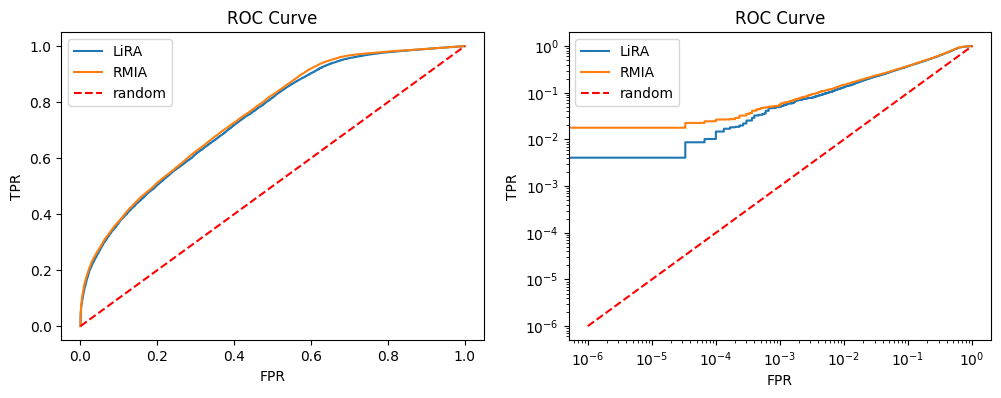

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend()
    plt.show()

mia_roc_curves = []
labels = []
for result in mia_results:
    fpr = getattr(result, 'fpr', None)
    tpr = getattr(result, 'tpr', None)
    if fpr is None or tpr is None:
        continue
    mia_roc_curves.append((fpr, tpr))
    labels.append(result.result_name)

if mia_roc_curves:
    plot_results(mia_roc_curves, labels=labels)
else:
    print('No ROC curves available to plot.')


In [15]:
from leakpro.attacks.mia_attacks.lira import AttackLiRA
from leakpro.attacks.mia_attacks.rmia import AttackRMIA
from leakpro.attacks.mia_attacks.base import AttackBASE

# Find first of each attack type
lira_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackLiRA)), None)
assert lira_attack is not None, "No attack of type LiRA was found."
rmia_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackRMIA)), None)
assert rmia_attack is not None, "No attack of type RMIA was found."
#base_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackBASE)), None)
#assert base_attack is not None, "No attack of type BASE was found."


In [16]:
from leakpro.attacks.utils.shadow_model_handler import ShadowModelHandler

def get_attack_intermediates(attack, verbose=True):
    
    # Get the audit dataset indices and labels from the attack
    audit_data_indices = attack.audit_dataset["data"]
    labels = attack.handler.get_labels(np.arange(len(attack.handler.population)))
    
    # query shadow model handler for intermediate data
    smh = ShadowModelHandler(attack.handler)
    target_logits = smh.load_logits(name="target")
    shadow_inmask = smh.get_in_indices_mask(attack.shadow_model_indices, attack.audit_dataset["data"])
    shadow_logits_list = [smh.load_logits(indx=indx) for indx in attack.shadow_model_indices]

    # Now create in indices mask for target model compliant with those for shadow
    target_inmask = np.zeros_like(audit_data_indices, dtype=bool)
    target_inmask[attack.train_indices] = True

    # Optionally output descriptive data
    if verbose:
        print("target_logits",target_logits.shape)
        print("len(shadow_logits_list)",len(shadow_logits_list))
        print("shadow_logits_list[0]",shadow_logits_list[0].shape)
        print("shadow_inmask",shadow_inmask.shape)
        print("target_inmask",shadow_inmask.shape)
        print("labels",labels.shape)

    return {
        "audit_data_indices": audit_data_indices, 
        "target_logits": target_logits, 
        "target_inmask": target_inmask, 
        "shadow_logits_list": shadow_logits_list, 
        "shadow_inmask": shadow_inmask, 
        "labels": labels
    }

rmia_cache = get_attack_intermediates(rmia_attack)    


2025-11-10 20:44:46,404 INFO     Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
11/10/2025 20:44:46:INFO:Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-10 20:44:46,409 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/10/2025 20:44:46:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-10 20:44:46,411 INFO     Loading metadata 0
11/10/2025 20:44:46:INFO:Loading metadata 0
2025-11-10 20:44:46,432 INFO     Loading metadata 1
11/10/2025 20:44:46:INFO:Loading metadata 1
2025-11-10 20:44:46,452 INFO     Loading metadata 2
11/10/2025 20:44:46:INFO:Loading metadata 2
2025-11-10 20:44:46,472 INFO     Loading metadata 3
11/10/2025 20:44:46:INFO:Loading metadata 3
2025-11-10 20:44:46,491 INFO     Loading metadata 4
11/10/2025 20:44:46:INFO:Loading metadata 4
2025-11-10 20:44:46,512 INFO     Loading metadata 5
11/10/2025 20:44:46:INFO:Loading metadata 5


target_logits (60000, 10)
len(shadow_logits_list) 64
shadow_logits_list[0] (60000, 10)
shadow_inmask (60000, 64)
target_inmask (60000, 64)
labels (60000,)


In [17]:
from leakpro.attacks.mia_attacks.rmia import rmia_get_gtlprobs

temperature = 1.0

target_gtl_probs = rmia_get_gtlprobs(rmia_cache["target_logits"], rmia_cache["labels"], temperature)
shadow_gtl_probs = np.vstack([
    rmia_get_gtlprobs(logits, rmia_cache["labels"], temperature) for logits in rmia_cache["shadow_logits_list"]
]).T

print("target_gtl_probs",target_gtl_probs.shape)
print("shadow_gtl_probs",shadow_gtl_probs.shape)


target_gtl_probs (60000,)
shadow_gtl_probs (60000, 64)


In [18]:
filepath = target_dir + "/intermediates/rmia"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/gtl_probabilities.npy", target_gtl_probs[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", rmia_cache["target_inmask"][:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", rmia_cache["audit_data_indices"])


store target results in  ./B/target/intermediates/rmia


In [19]:
filepath = shadow_dir + "/intermediates/rmia"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/gtl_probabilities.npy", shadow_gtl_probs)
np.save(filepath + "/in_indices_masks.npy", rmia_cache["shadow_inmask"])
np.save(filepath + "/audit_data_indices.npy", rmia_cache["audit_data_indices"])


store shadow results in  ./B/output/intermediates/rmia


In [20]:
lira_cache = get_attack_intermediates(lira_attack)    


2025-11-10 20:44:51,550 INFO     Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
11/10/2025 20:44:51:INFO:Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-10 20:44:51,554 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/10/2025 20:44:51:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-10 20:44:51,556 INFO     Loading metadata 0
11/10/2025 20:44:51:INFO:Loading metadata 0
2025-11-10 20:44:51,576 INFO     Loading metadata 1
11/10/2025 20:44:51:INFO:Loading metadata 1
2025-11-10 20:44:51,595 INFO     Loading metadata 2
11/10/2025 20:44:51:INFO:Loading metadata 2
2025-11-10 20:44:51,615 INFO     Loading metadata 3
11/10/2025 20:44:51:INFO:Loading metadata 3
2025-11-10 20:44:51,635 INFO     Loading metadata 4
11/10/2025 20:44:51:INFO:Loading metadata 4
2025-11-10 20:44:51,654 INFO     Loading metadata 5
11/10/2025 20:44:51:INFO:Loading metadata 5


target_logits (60000, 10)
len(shadow_logits_list) 64
shadow_logits_list[0] (60000, 10)
shadow_inmask (60000, 64)
target_inmask (60000, 64)
labels (60000,)


In [21]:
target_rs_logits = lira_attack.rescale_logits(lira_cache["target_logits"], lira_cache["labels"])
shadow_rs_logits = np.vstack([
    lira_attack.rescale_logits(logits, lira_cache["labels"]) for logits in lira_cache["shadow_logits_list"]
]).T

print("target_rs_logits",target_rs_logits.shape)
print("shadow_rs_logits",shadow_rs_logits.shape)


target_rs_logits (60000,)
shadow_rs_logits (60000, 64)


In [22]:
filepath = target_dir + "/intermediates/lira"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", target_rs_logits[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", lira_cache["target_inmask"][:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", lira_cache["audit_data_indices"])


store target results in  ./B/target/intermediates/lira


In [23]:
filepath = shadow_dir + "/intermediates/lira"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", shadow_rs_logits)
np.save(filepath + "/in_indices_masks.npy", lira_cache["shadow_inmask"])
np.save(filepath + "/audit_data_indices.npy", lira_cache["audit_data_indices"])


store shadow results in  ./B/output/intermediates/lira
